In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
# import gseapy as gp
# import squidpy as sq
from bin import load_bgi as ld
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
sc.settings.verbosity = 3
# import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, norm
from scipy.signal import find_peaks
import os
from statannotations.Annotator import Annotator
from itertools import combinations
from scipy.stats import ttest_ind,wilcoxon

%config InlineBackend.figure_format='retina'
%matplotlib inline
plt.rcParams['figure.figsize']=(7,4)


ModuleNotFoundError: No module named 'load_bgi'

In [2]:
def plot_freq(data_object, sample, cell_type, density=True,sort=False,figsize=(3.5,4)):
    sc.settings.set_figure_params(dpi=80)
    try: 
        row = list(data_object.obs[sample].cat.categories)
        column = list(data_object.obs[cell_type].cat.categories) 
    except:
        row=list(set(data_object.obs[sample]))
        column =  list(set(data_object.obs[cell_type]))
    
    data = data_object.obs[[sample,cell_type]]
    data[cell_type] = np.array(data[cell_type])
    # data = data.loc[data["cell_type"].isin(['B',"DC","Macrophage",'Myeloid','NK','T']),:]
    # data = data.loc[data["cell_type"].isin(['Tumor',	'Tumor_low_counts',	'Tumor_mitotic']),:]
    if density:
        b=pd.DataFrame(data.groupby(sample)[cell_type].value_counts(normalize=True))
        b.columns= ['Freq']
        b=b.reset_index()
        b = b.pivot(index=sample, columns=cell_type)

    else:
        b=data.groupby(sample)[cell_type].value_counts().reset_index()
        b.columns= [sample,cell_type,'freq']
        b = b.pivot(index=sample, columns=cell_type)
        
    # plt.title("Tumor cell")
    
    b.index.name = None
    b.columns.names = [None,None]
    b.columns = b.columns.droplevel(0)
    # print(b)
    
    plt.style.use("seaborn-pastel")
    b = b.loc[row,column]
    if sort:
        b=b.sort_values(b.columns[-1])
    # print(b)
    b.plot(kind='bar',stacked=True,figsize=figsize,grid=False,table=False,legend=True, cmap='tab20c') # Set3 
    # plt.xticks(range(len(row)),row,rotation=90)
    # plt.xticks([0,1,2],["","",""],rotation=45)
    # plt.xticks([],rotation=45)        
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05,0), loc=3, borderaxespad=0)
    plt.show()
    

In [3]:
# from sklearn.neighbors import NearestNeighbors 
# ChatGPT优化后的代码
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
def create_adjacency_matrix(X, radius=50, n_neighbors=4):
    # one pixel equals to 500nm
    # bin200 100um
    # bin50 25um
    # bin1 = 500nm
    #  50um  

    # nbrs = NearestNeighbors(n_neighbors=n_neighbors, radius=radius, metric='euclidean').fit(X)
    # adj_matrix = pd.DataFrame(nbrs.kneighbors_graph(X, mode='connectivity').toarray(), dtype=np.int8)
    adj_matrix= kneighbors_graph(X, n_neighbors=n_neighbors, mode='distance', include_self=False)
    adj_matrix_coo = adj_matrix.tocoo()
    # plt.hist(adj_matrix_coo.data)
    plt.show()
    
    radius = radius*2 
    
    mask = (adj_matrix_coo.data > 0) & (adj_matrix_coo.data <= radius)
    row = adj_matrix_coo.row[mask]
    col = adj_matrix_coo.col[mask]
    data = np.ones(row.shape[0], dtype=int)
    adj_matrix_filtered = csr_matrix((data, (row, col)), shape=adj_matrix.shape).tocoo()
    
    return adj_matrix_filtered 

# 原代码
# def create_adjacency_matrix(X, method='KNN graph', radius=50, n_neighbors=4): 
#     if method == 'KNN graph':
#         adj_matrix= kneighbors_graph(X, n_neighbors=n_neighbors, mode='distance', include_self=False).toarray()     
#         adj_matrix = adj_matrix * 0.5 
#         adj_matrix  = pd.DataFrame(np.array((adj_matrix <radius) & (adj_matrix >0),dtype=int))
#     else:
#         raise ValueError("Unsupported method. Choose 'KNN graph' or 'Delaunay'.")
#     return adj_matrix

# Different BULK transcriptome in different regions

In [46]:
import os

samples = os.listdir('/home/zhaoyp/0.CRLM_ST/data/gem_data/CRLM')
samples = [x for x in samples if x!='raw']
l = [x for x in samples if 'LM' in x ]
c = [x for x in samples if 'CC' in x]
samples = l+c
samples = [x for x in samples if "SEM" not in x]



In [47]:
region_transcriptome = {}


# for sample in samples:
for sample in samples:
    adata = sc.read('/home/zhaoyp/0.CRLM_ST/res/Anndata/bin20/'+ sample + '_Border_finetune_3kHVGsCluster.h5ad')
    adata = adata.raw.to_adata()

    df = pd.DataFrame(adata.X.toarray(), index = adata.obs.index, columns = adata.var_names)
    df['loc'] = adata.obs['loc']
    df = df.groupby('loc').agg(['sum']) 
    
    df.index.name = None
    df.columns.names = [None,None]
    df.columns = list(df.columns.droplevel(1))

    region_transcriptome[sample] = df



In [54]:
tmp = region_transcriptome

In [51]:
region_transcriptome.keys()


dict_keys(['20231121_HLB_LM', '20230907_LM', '20230411_LM', '20231128_PTX_LM', '20231019_LM', '20230725_LM', '20230608_LM', '20230516_LM', '20230914_LM', '20230516_CC', '20231121_HLB_CC', '20230725_CC', '20230411_CC', '20231019_CC', '20230608_CC', '20230914_CC', '20230907_CC', '20231128_PTX_CC'])

In [62]:
for key in tmp.keys():
    tmp[key].index = list(tmp[key].index)
    tmp[key].index = [key+"-"+x for x in tmp[key].index]
    


In [66]:
df = pd.concat([tmp[key] for key in tmp.keys()])

In [67]:
df.to_csv('/home/zhaoyp/0.CRLM_ST/res/TumorBorderRegion/BulkTranscriptomeAmongRegions.csv')

## Import data

In [218]:
df = pd.read_csv('/home/zhaoyp/0.CRLM_ST/res/TumorBorderRegion/BulkTranscriptomeAmongRegions.csv')
df = df.fillna(0)
print(df.shape)

(54, 36582)


In [219]:
sample = df.iloc[:,0]
df = df.iloc[:,1:]

In [220]:
sample = ['P'+x.split('-')[0][4:9]+x.split('-')[0][-2:] +'-'+ x.split('-')[1] for x in list(sample)]

In [222]:
df = df.loc[:,(df >0 ).sum(axis=0)[(df >0 ).sum(axis=0) > df.shape[0] * 0.9].index]
df.shape

(54, 21733)

In [223]:
genes = [ x for x in df.columns if "-" not in x]
genes = [ x for x in genes if "_" not in x]
df = df[genes]
df.shape

(54, 20037)

In [224]:
df = df.div(df.sum(axis=1),axis=0) * 1e6

In [225]:
df['sample'] = sample

In [226]:
df.to_csv('/home/zhaoyp/0.CRLM_ST/res/TumorBorderRegion/stat.csv')

# The celltype compostion in differ regions

In [70]:
import os

samples = os.listdir('/home/zhaoyp/0.CRLM_ST/data/gem_data/CRLM')
samples = [x for x in samples if x!='raw']
l = [x for x in samples if 'LM' in x ]
c = [x for x in samples if 'CC' in x]
samples = l+c
samples = [x for x in samples if "SEM" not in x]


In [71]:
region_celltype = {}


for sample in samples:
# for sample in ['20231121_HLB_LM']:
    print(sample)
    adata = sc.read('/home/zhaoyp/0.CRLM_ST/res/Anndata/bin20/'+ sample + '_Border_finetune_3kHVGsCluster.h5ad')
    # adata = adata.raw.to_adata()

    df = pd.DataFrame(adata.obs['celltype_1'], index = adata.obs.index, columns = ['celltype_1']) 
    df['loc'] = adata.obs['loc']
    
    df = pd.DataFrame(df[['loc','celltype_1']].value_counts()).reset_index()
    df.columns = [['region','celltype_1','value']]
    df['sample'] = sample
    
    region_celltype[sample] = df


20231121_HLB_LM
20230907_LM
20230411_LM
20231128_PTX_LM
20231019_LM
20230725_LM
20230608_LM
20230516_LM
20230914_LM
20230516_CC
20231121_HLB_CC
20230725_CC
20230411_CC
20231019_CC
20230608_CC
20230914_CC
20230907_CC
20231128_PTX_CC


In [73]:
df = pd.DataFrame(pd.concat([ region_celltype[key] for key in region_celltype.keys()]))
df['sample'] = ['P'+x[0][4:8]+x[0][-3:] for x in df['sample'].values]
df['sample_region'] = [df.iloc[i,3]+'-'+df.iloc[i,0] for i in range(df.shape[0])]
df.columns = ['region','celltype_1','value','sample','sample_region'] 

df = df.pivot_table(index='sample_region', columns='celltype_1',values='value')
df.index.name = None
df = df.fillna(0)
df = df.div(df.sum(axis=1),axis=0) 
df['sample_region'] = list(df.index)

df = df.melt(id_vars=['sample_region'])
df['sample'] = [x.split('-')[0] for x in df['sample_region']]
df['region'] = [x.split('-')[1] for x in df['sample_region']]
df['tissue'] = [x.split('_')[1] for x in df['sample']]
df['group'] = [df.iloc[i,-1]+"_"+df.iloc[i,-2] for i in range(df.shape[0])]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophages_CC_Normal vs. Macrophages_LM_Border: t-test paired samples, P_val:4.024e-04 t=-5.806e+00
Others_CC_Normal vs. Others_LM_Border: t-test paired samples, P_val:1.417e-02 t=3.123e+00
MuscleCell_CC_Normal vs. MuscleCell_LM_Border: t-test paired samples, P_val:3.877e-02 t=2.469e+00
Hepatocytes_CC_Normal vs. Hepatocytes_LM_Border: t-test paired samples, P_val:3.519e-03 t=-4.083e+00
Malignant_CC_Normal vs. Malignant_LM_Border: t-test paired samples, P_val:2.863e-02 t=-2.664e+00
Fibroblast_CC_Normal vs. Fibroblast_LM_Border: t-test paired samples, P_val:6.947e-01 t=4.070e-01
Fibroblast_CC_Border vs. Fibroblast_CC_Normal: t-test paired samples, P_val:4.483e-01 t=-7.973e-01
Endothelial_CC_Normal vs. Endothelial_LM_Border: t-test paired samples, P_val:1.391e-02 t=3.135e+00
Malignant_CC_Border vs. 

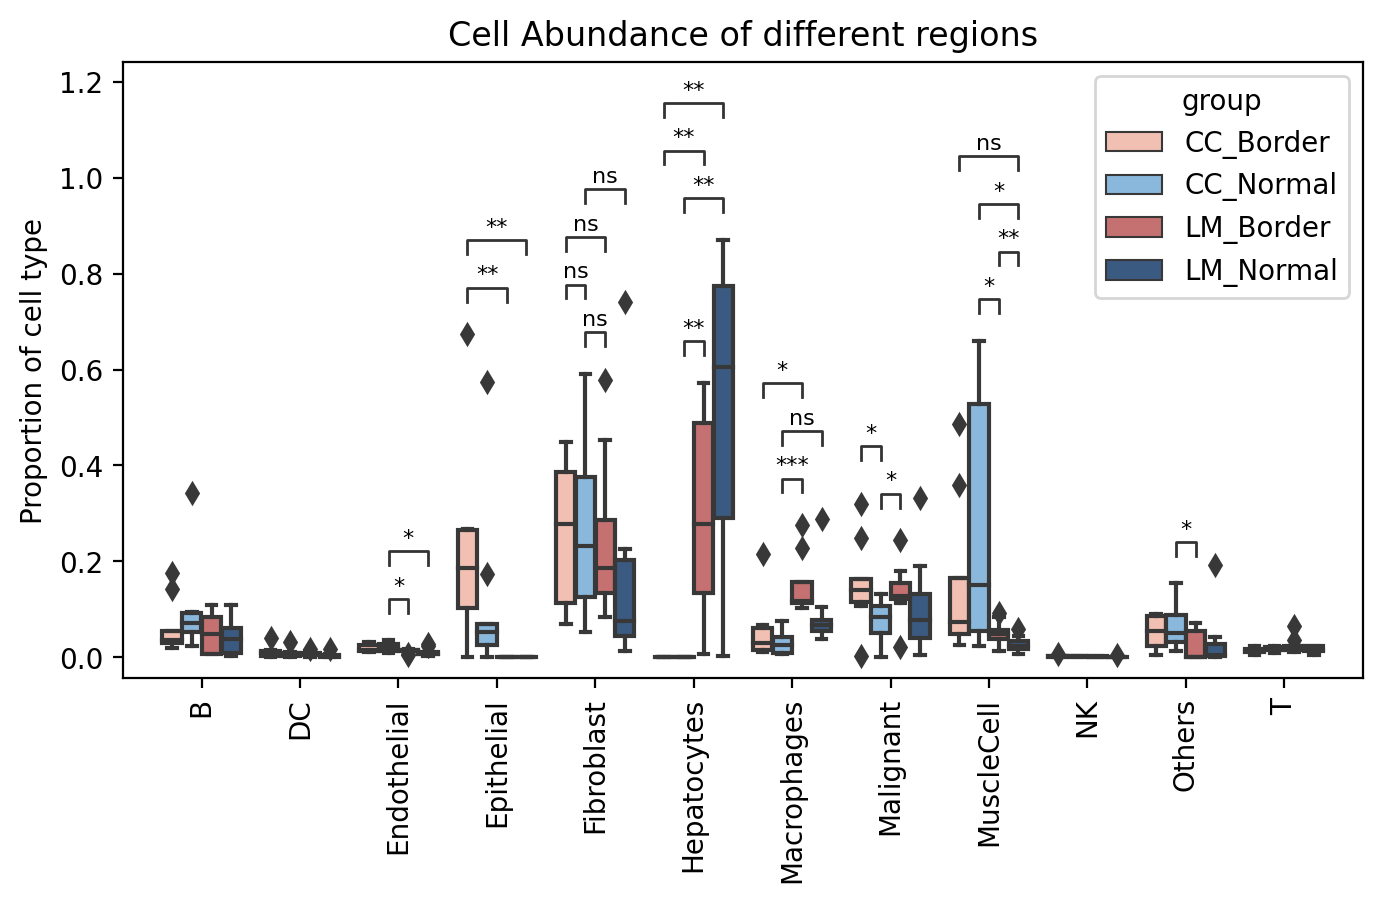

In [94]:
from statannotations.Annotator import Annotator

df_noTumor = df[df['region'].isin(['Border','Normal'])]
df_noTumor = df_noTumor.sort_values(['sample_region','group','celltype_1'])

pltfig, ax = plt.subplots(figsize=(8,4))

sns.boxplot( x=df_noTumor['celltype_1'], y=df_noTumor['value'],hue=df_noTumor['group'], ax=ax,
            palette = {'CC_Border': '#FDBAA7', 'CC_Normal': '#7BBAEA', 'LM_Border': '#D46363', 'LM_Normal': '#30598C'} )

groups = list(set([tuple(x) for x in df_noTumor[['celltype_1','group']].values]))
groups_combinations = list(combinations(groups,2))
groups_final = []
for x in groups_combinations:
    if x[0][0]==x[1][0]:
        groups_final.append(x)

groups_stat = []
for group in groups_final:
    celltype1 = group[0][0]
    tmp_df = df_noTumor[df_noTumor['celltype_1'].isin([celltype1])]
    group0 =  group[0][1]
    group1 =  group[1][1]
    lst1 = tmp_df[tmp_df['group'].isin([group0])]['value']
    lst2 = tmp_df[tmp_df['group'].isin([group1])]['value']
    try:
        t_stat, p_val = ttest_ind(lst1, lst2) #  ttest_ind
        if p_val < 0.05:  # Choose your significance level here
            groups_stat.append(group)
    except:
        continue

groups_stat= groups_stat + [(('Fibroblast', 'CC_Normal'), ('Fibroblast', 'LM_Normal')),
                    (('Fibroblast', 'CC_Normal'), ('Fibroblast', 'LM_Border')),
                    (('Fibroblast', 'CC_Normal'), ('Fibroblast', 'CC_Border')),
                    (('Fibroblast', 'LM_Border'), ('Fibroblast', 'CC_Border'))]

pairs=groups_stat 
annotator = Annotator(ax, pairs, data=df_noTumor, x='celltype_1', y='value',hue='group') 

annotator.configure(test='t-test_paired', text_format='star', line_height=0.03, line_width=1, fontsize=8) #Mann-Whitney
annotator.apply_and_annotate() 
# ax.tick_params(which='major', direction='in', length=3, width=1., labelsize=10, bottom=False)  

plt.xticks(rotation=90)
plt.title('Cell Abundance of different regions') 
plt.xlabel('')
plt.ylabel('Proportion of cell type')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MuscleCell_CC_Normal vs. MuscleCell_LM_Border: t-test paired samples, P_val:3.877e-02 t=2.469e+00
Macrophages_LM_Border vs. Macrophages_LM_Normal: t-test paired samples, P_val:3.375e-03 t=4.113e+00
Malignant_CC_Border vs. Malignant_CC_Normal: t-test paired samples, P_val:2.363e-02 t=2.788e+00
Malignant_CC_Normal vs. Malignant_LM_Border: t-test paired samples, P_val:2.863e-02 t=-2.664e+00
Fibroblast_CC_Border vs. Fibroblast_CC_Normal: t-test paired samples, P_val:4.483e-01 t=-7.973e-01
Macrophages_CC_Normal vs. Macrophages_LM_Border: t-test paired samples, P_val:4.024e-04 t=-5.806e+00
MuscleCell_LM_Border vs. MuscleCell_LM_Normal: t-test paired samples, P_val:6.526e-03 t=3.647e+00
Fibroblast_CC_Normal vs. Fibroblast_LM_Border: t-test paired samples, P_val:6.947e-01 t=4.070e-01
T_CC_Border vs. T_LM_

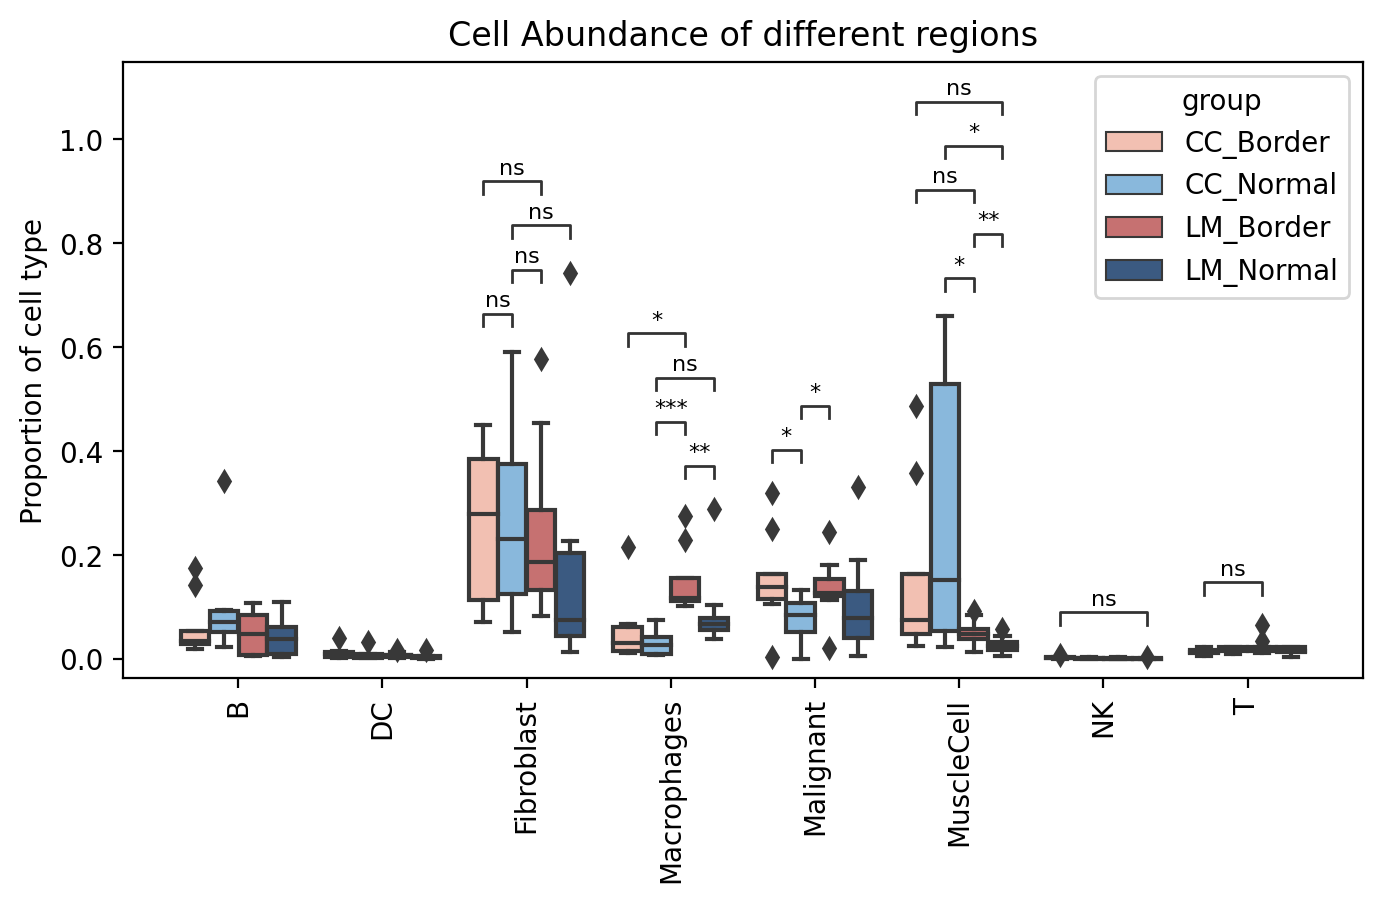

In [95]:
from statannotations.Annotator import Annotator

df_noTumor = df[df['region'].isin(['Border','Normal'])]
df_noTumor = df_noTumor[~ df_noTumor['celltype_1'].isin(['Hepatocytes', 'Epithelial','Others','Endothelial'])]
df_noTumor = df_noTumor.sort_values(['sample_region','group','celltype_1'])

pltfig, ax = plt.subplots(figsize=(8,4))

sns.boxplot( x=df_noTumor['celltype_1'], y=df_noTumor['value'],hue=df_noTumor['group'], ax=ax,
            palette = {'CC_Border': '#FDBAA7', 'CC_Normal': '#7BBAEA', 'LM_Border': '#D46363', 'LM_Normal': '#30598C'} )

groups = list(set([tuple(x) for x in df_noTumor[['celltype_1','group']].values]))
groups_combinations = list(combinations(groups,2))
groups_final = []
for x in groups_combinations:
    if x[0][0]==x[1][0]:
        groups_final.append(x)

groups_stat = []
for group in groups_final:
    celltype1 = group[0][0]
    tmp_df = df_noTumor[df_noTumor['celltype_1'].isin([celltype1])]
    group0 =  group[0][1]
    group1 =  group[1][1]
    lst1 = tmp_df[tmp_df['group'].isin([group0])]['value']
    lst2 = tmp_df[tmp_df['group'].isin([group1])]['value']
    try:
        t_stat, p_val = ttest_ind(lst1, lst2) #  ttest_ind
        if p_val < 0.1:  # Choose your significance level here
            groups_stat.append(group)
    except:
        continue

groups_stat= groups_stat + [(('Fibroblast', 'CC_Normal'), ('Fibroblast', 'LM_Normal')),
                    (('Fibroblast', 'CC_Normal'), ('Fibroblast', 'LM_Border')),
                    (('Fibroblast', 'CC_Normal'), ('Fibroblast', 'CC_Border')),
                    (('Fibroblast', 'LM_Border'), ('Fibroblast', 'CC_Border'))]

pairs=groups_stat 
annotator = Annotator(ax, pairs, data=df_noTumor, x='celltype_1', y='value',hue='group') 

annotator.configure(test='t-test_paired', text_format='star', line_height=0.03, line_width=1, fontsize=8) #Mann-Whitney
annotator.apply_and_annotate() 
# ax.tick_params(which='major', direction='in', length=3, width=1., labelsize=10, bottom=False)  

plt.xticks(rotation=90)
plt.title('Cell Abundance of different regions') 
plt.xlabel('')
plt.ylabel('Proportion of cell type')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MuscleCell_CC_Normal vs. MuscleCell_LM_Border: t-test paired samples, P_val:3.877e-02 t=2.469e+00
Macrophages_LM_Border vs. Macrophages_LM_Normal: t-test paired samples, P_val:3.375e-03 t=4.113e+00
Malignant_CC_Border vs. Malignant_CC_Normal: t-test paired samples, P_val:2.363e-02 t=2.788e+00
Malignant_CC_Normal vs. Malignant_LM_Border: t-test paired samples, P_val:2.863e-02 t=-2.664e+00
Fibroblast_CC_Border vs. Fibroblast_CC_Normal: t-test paired samples, P_val:4.483e-01 t=-7.973e-01
Macrophages_CC_Normal vs. Macrophages_LM_Border: t-test paired samples, P_val:4.024e-04 t=-5.806e+00
MuscleCell_LM_Border vs. MuscleCell_LM_Normal: t-test paired samples, P_val:6.526e-03 t=3.647e+00
Fibroblast_CC_Normal vs. Fibroblast_LM_Border: t-test paired samples, P_val:6.947e-01 t=4.070e-01
T_CC_Border vs. T_LM_

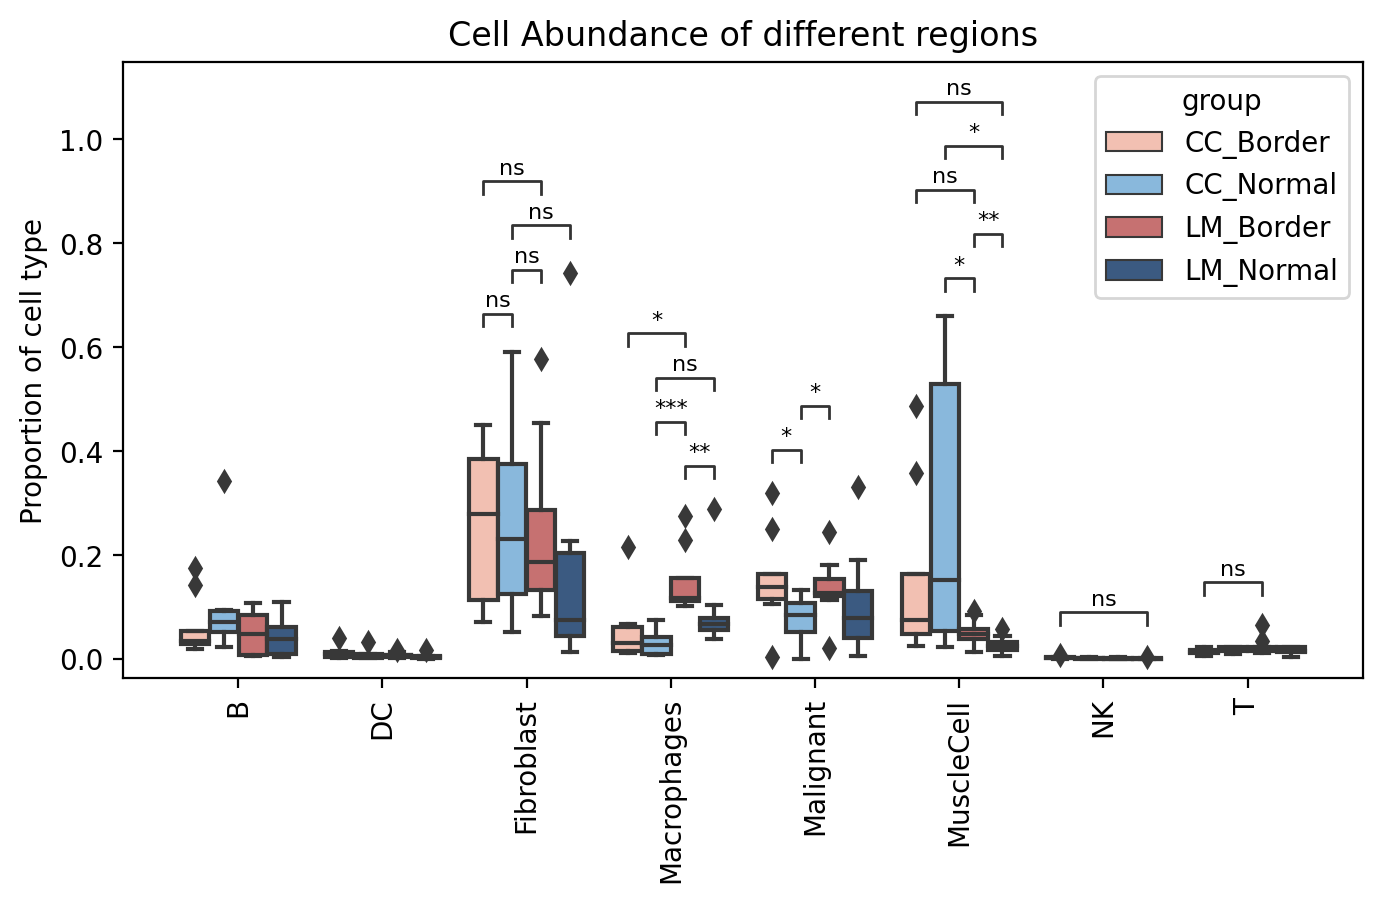

In [97]:
from statannotations.Annotator import Annotator

df_noTumor = df[df['region'].isin(['Border','Normal'])]
df_noTumor = df_noTumor[~ df_noTumor['celltype_1'].isin(['Hepatocytes', 'Epithelial','Others','Endothelial'])]
df_noTumor = df_noTumor.sort_values(['sample_region','group','celltype_1'])
df_noTumor[~ df_noTumor['sample'].isin(['P1019_LM'])]
df_noTumor[~ df_noTumor['sample'].isin(['P1019_CC'])]

pltfig, ax = plt.subplots(figsize=(8,4))

sns.boxplot( x=df_noTumor['celltype_1'], y=df_noTumor['value'],hue=df_noTumor['group'], ax=ax,
            palette = {'CC_Border': '#FDBAA7', 'CC_Normal': '#7BBAEA', 'LM_Border': '#D46363', 'LM_Normal': '#30598C'} )

groups = list(set([tuple(x) for x in df_noTumor[['celltype_1','group']].values]))
groups_combinations = list(combinations(groups,2))
groups_final = []
for x in groups_combinations:
    if x[0][0]==x[1][0]:
        groups_final.append(x)

groups_stat = []
for group in groups_final:
    celltype1 = group[0][0]
    tmp_df = df_noTumor[df_noTumor['celltype_1'].isin([celltype1])]
    group0 =  group[0][1]
    group1 =  group[1][1]
    lst1 = tmp_df[tmp_df['group'].isin([group0])]['value']
    lst2 = tmp_df[tmp_df['group'].isin([group1])]['value']
    try:
        t_stat, p_val = ttest_ind(lst1, lst2) #  ttest_ind
        if p_val < 0.1:  # Choose your significance level here
            groups_stat.append(group)
    except:
        continue

groups_stat= groups_stat + [(('Fibroblast', 'CC_Normal'), ('Fibroblast', 'LM_Normal')),
                    (('Fibroblast', 'CC_Normal'), ('Fibroblast', 'LM_Border')),
                    (('Fibroblast', 'CC_Normal'), ('Fibroblast', 'CC_Border')),
                    (('Fibroblast', 'LM_Border'), ('Fibroblast', 'CC_Border'))]

pairs=groups_stat 
annotator = Annotator(ax, pairs, data=df_noTumor, x='celltype_1', y='value',hue='group') 

annotator.configure(test='t-test_paired', text_format='star', line_height=0.03, line_width=1, fontsize=8) #Mann-Whitney
annotator.apply_and_annotate() 
# ax.tick_params(which='major', direction='in', length=3, width=1., labelsize=10, bottom=False)  

plt.xticks(rotation=90)
plt.title('Cell Abundance of different regions') 
plt.xlabel('')
plt.ylabel('Proportion of cell type')
plt.show()

In [76]:
df_border=df[df['region'].isin(['Border'])]
df_Normal=df[df['region'].isin(['Normal'])]

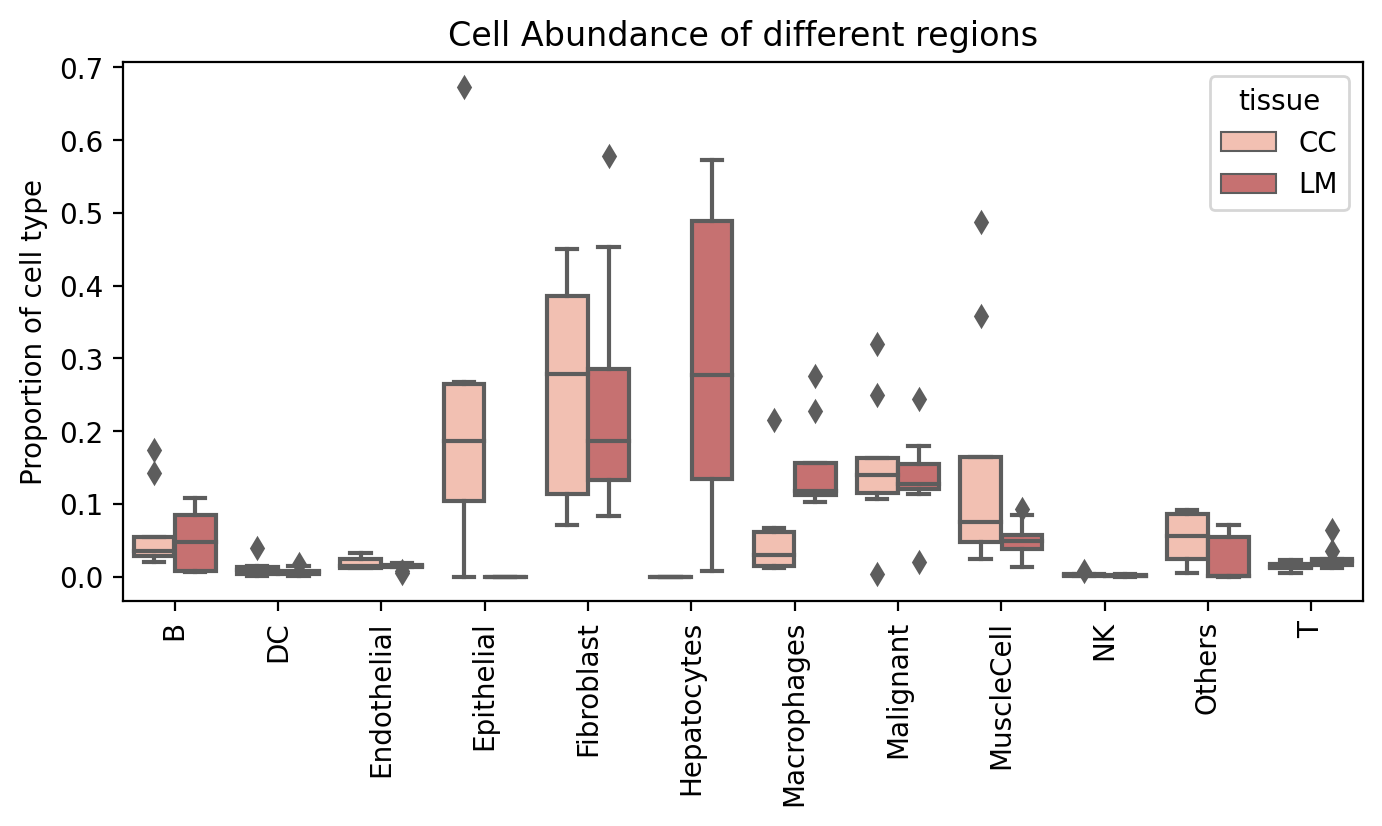

In [77]:
plt.rcParams["figure.figsize"] = (8, 3.5)

sns.boxplot( x=df_border['celltype_1'], y=df_border['value'],hue=df_border['tissue'],palette={'CC':'#FDBAA7', 'LM':'#D46363'})
plt.xticks(rotation=90)
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Cell Abundance of different regions') 
plt.xlabel('')
plt.ylabel('Proportion of cell type')
plt.show()


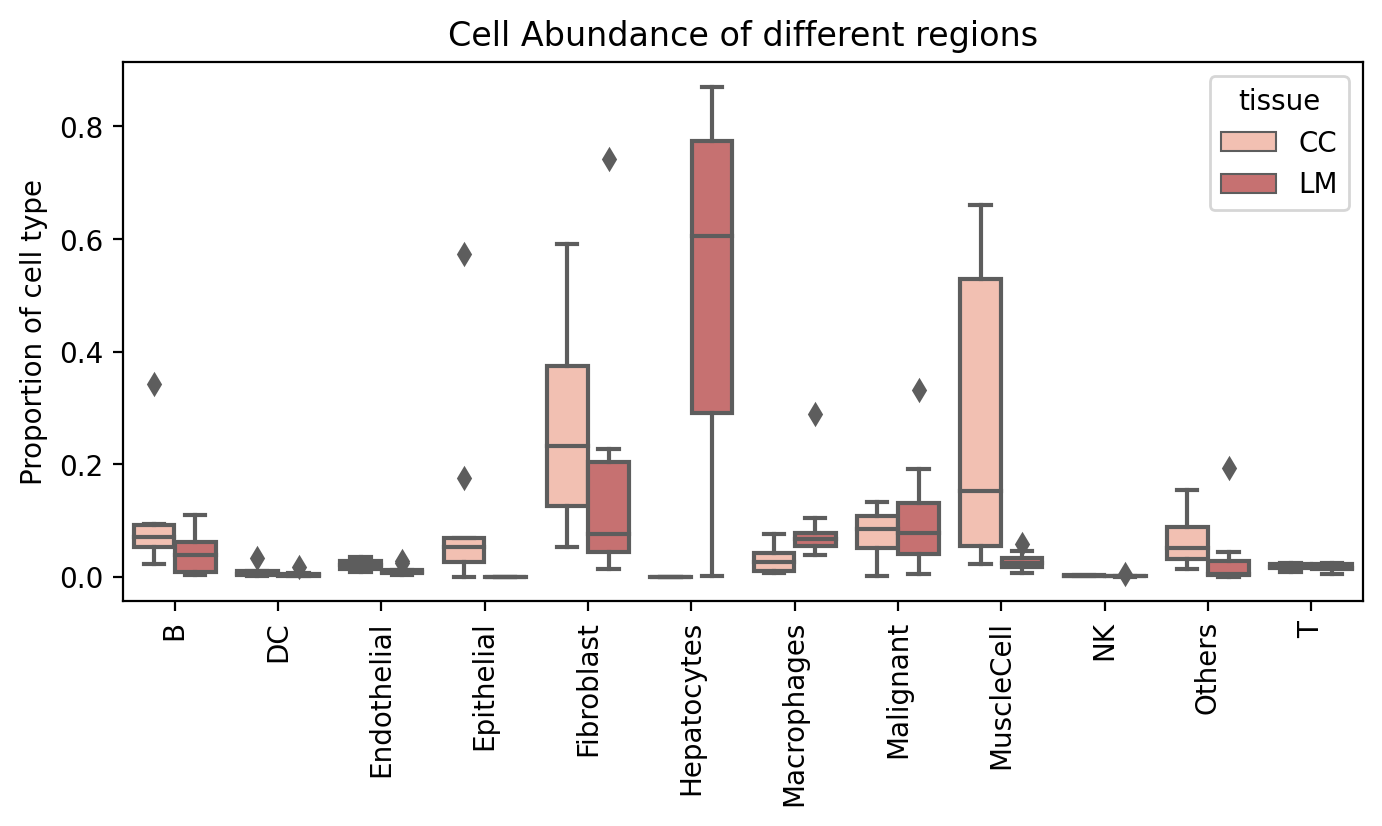

In [78]:
plt.rcParams["figure.figsize"] = (8, 3.5)

sns.boxplot( x=df_Normal['celltype_1'], y=df_Normal['value'],hue=df_Normal['tissue'],palette={'CC':'#FDBAA7', 'LM':'#D46363'})
plt.xticks(rotation=90)
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Cell Abundance of different regions') 
plt.xlabel('')
plt.ylabel('Proportion of cell type')
plt.show()


# Hallmark expression in different regions

In [4]:
import os

samples = os.listdir('/home/zhaoyp/0.CRLM_ST/data/gem_data/CRLM')
samples = [x for x in samples if x!='raw']
l = [x for x in samples if 'LM' in x ]
c = [x for x in samples if 'CC' in x]
samples = l+c
samples = [x for x in samples if "SEM" not in x]


In [5]:

hallmark_all = pd.read_csv('/home/zhaoyp/0.CRLM_ST/res/CellAnno/HallmarkSig/hallmark.csv')
hallmark_name_2 = ['AntigenPresen', 'adipogenesis', 'allograft_rejection','angiogenesis', 'apoptosis',
       'bile_acid_metabolism', 'cholesterol_homeostasis', 'complement','dna_repair','epithelial_mesenchymal_transition',
       'fatty_acid_metabolism', 'g2m_checkpoint', 'glycolysis','hypoxia', 'il2_stat5_signaling',
       'il6_jak_stat3_signaling', 'inflammatory_response','interferon_alpha_response', 'interferon_gamma_response',
        'kras_signaling_up', 'mitotic_spindle','mtorc1_signaling', 'myc_targets_v1', 'myc_targets_v2', 'myogenesis',
        'oxidative_phosphorylation', 'p53_pathway','pi3k_akt_mtor_signaling', 'reactive_oxygen_species_pathway', 'tgf_beta_signaling', 'tnfa_signaling_via_nfkb',
       'unfolded_protein_response', 'uv_response_dn', 'uv_response_up',  'wnt_beta_catenin_signaling', 'xenobiotic_metabolism']


region_hallmark  = {}

In [6]:
cytokine_receptor_interaction = ['VEGFA', 'PGF', 'CCL15', 'IFNE', 'TNFSF9', 'CCL24', 'TFF2', 'CX3CL1', 'TGFBR3', 'CCL16', 'CCL25', 'DEFB4A', 'FADD', 'TRAF3', 
    'CXCL10', 'PPBP', 'CD40LG', 'CXCL1', 'CXCL3', 'CXCL2', 'NOL3', 'DEFB103A', 'TGFBR3L', 'CCL19', 'CXCL11', 'CSF3', 'CCL11', 'TNF', 'NES', 'XCL1', 'IFNA2', 
                                 'IFNA10', 'IFNA21', 'IFNA5', 'IFNA17', 'IFNB1', 'CNTF', 'CXCL12', 'CCL20', 'CADM4', 'JAK3', 'CCL4L1', 'CCL27', 'CCL3', 'CXCL8', 
                                 'DEFB109B', 'DEFB110', 'DEFB114', 'DEFB133', 'PF4V1', 'IL27', 'NTF3', 'CCL26', 'IL23R', 'LIFR', 'CCL28', 'NTF4', 'IL34', 
                                 'TGFBR2', 'ENG', 'CSH2', 'CSH1', 'CXCL13', 'VEGFD', 'PDCL3', 'CCL14', 'DEFB130A', 'DEFB130B', 'TNFSF18', 'IFNA8', 'TYK2', 
                                 'VEGFC', 'VEGFB', 'IL1RAP', 'CXCL5', 'CCL1', 'CXCL16', 'XCL2', 'CSHL1', 'LIF', 'PF4', 'TRAF4', 'EDA', 'JAK2', 'IFNA16', 
                                 'IFNA4', 'IFNA6', 'IFNW1', 'IL9', 'TSLP', 'IL31', 'BDNF', 'TNFSF4', 'IFNK', 'CCL4', 'TRAF2', 'TRAF1', 'CCL18', 'CCL23', 'CCL5', 
                                 'CCL2', 'NGF', 'KITLG', 'CXCL6', 'CCL17', 'OSMR', 'CCL7', 'CCL8', 'S100A14', 'CCL13', 'GH2', 'GH1', 'CXCL9', 'IL1RN', 'PRL', 
                                 'EPO', 'IFNA14', 'IFNA7', 'IFNA1', 'CCL21', 'DEFB1', 'JAK1', 'SIVA1', 'CCL3L1', 'CCL22', 'TRIM37', 'TRAF5']


In [7]:
score_names = hallmark_name_2 + ['cytokine_receptor_interaction'] 

In [8]:
region_hallmark = {}

for sample in samples:
    print(sample)
    adata = sc.read('/home/zhaoyp/0.CRLM_ST/res/Anndata/bin20/'+ sample + '_Border_finetune_3kHVGsCluster.h5ad')
    sc.tl.score_genes(adata, cytokine_receptor_interaction, score_name='cytokine_receptor_interaction')

    hallmark = hallmark_all[hallmark_all['sample']==sample]
    hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
    hallmark.index = list(hallmark.iloc[:,0].astype(str))
    hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
    adata.obs = pd.merge(adata.obs, hallmark, left_index=True, right_index=True)

    df = pd.DataFrame(adata.obs[score_names], index = adata.obs.index, columns = score_names)
    df['loc'] = adata.obs['loc']
    df['sample'] = sample

    region_hallmark[sample] = df



20231121_HLB_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1194 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230907_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1194 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230411_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1094 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20231128_PTX_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1150 total control genes are used. (0:00:03)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20231019_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1197 total control genes are used. (0:00:01)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230725_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1142 total control genes are used. (0:00:00)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230608_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1197 total control genes are used. (0:00:00)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230516_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1196 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230914_LM
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1197 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230516_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1195 total control genes are used. (0:00:03)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20231121_HLB_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1195 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230725_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1096 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230411_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1195 total control genes are used. (0:00:01)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20231019_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1145 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230608_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1196 total control genes are used. (0:00:04)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230914_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1197 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20230907_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1097 total control genes are used. (0:00:01)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


20231128_PTX_CC
computing score 'cytokine_receptor_interaction'
    finished: added
    'cytokine_receptor_interaction', score of gene set (adata.obs).
    1095 total control genes are used. (0:00:02)


/tmp/ipykernel_37690/1657007358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)
/tmp/ipykernel_37690/1657007358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hallmark.drop(hallmark.columns[0],axis=1,inplace=True)


In [9]:
hallmark_df = pd.concat(region_hallmark)
hallmark_df.reset_index(inplace=True)
hallmark_df = hallmark_df.iloc[:,2:]
hallmark_df['sample'] = ["P"+x[4:9]+x[-2:] for x in hallmark_df['sample']]
hallmark_df['group']= [x[0]+'_'+x[1] for x in list(zip( [x[-2:] for x in hallmark_df['sample']], hallmark_df['loc']))]


In [11]:
hallmark_df = hallmark_df.melt(id_vars=['loc','sample','group']) 
hallmark_df.columns = ['region','sample','group','hallmark','score']

AntigenPresen


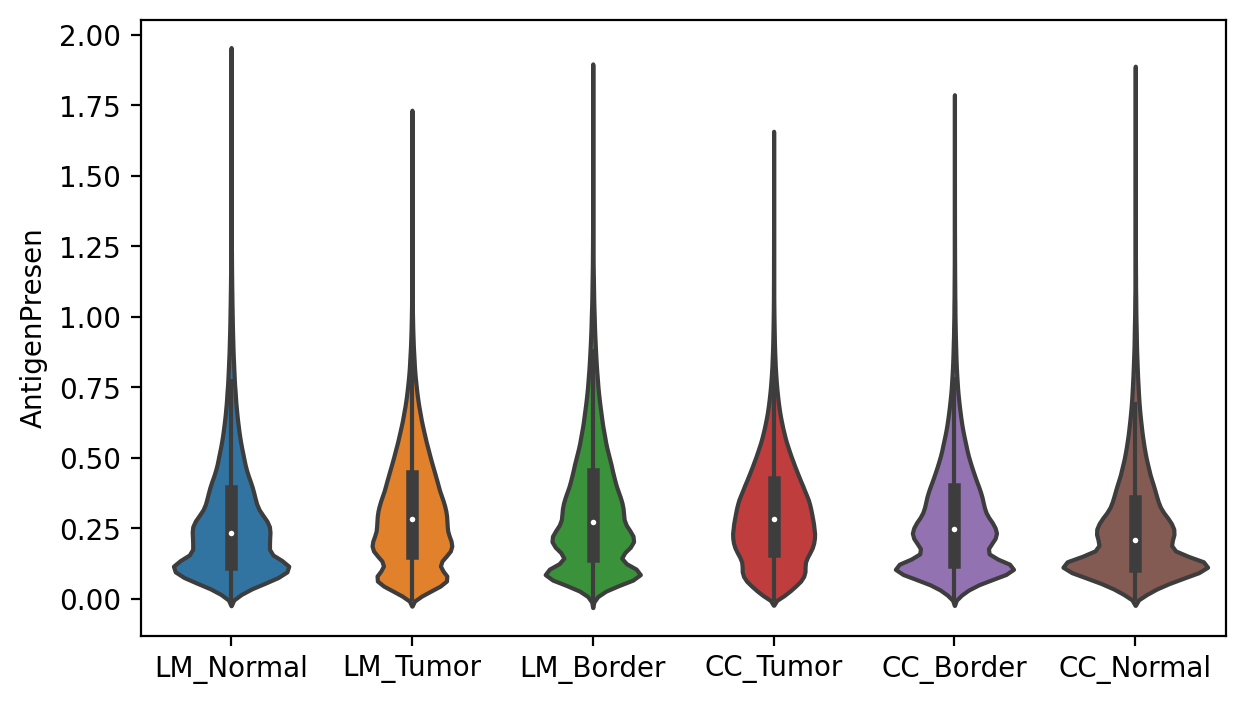

adipogenesis


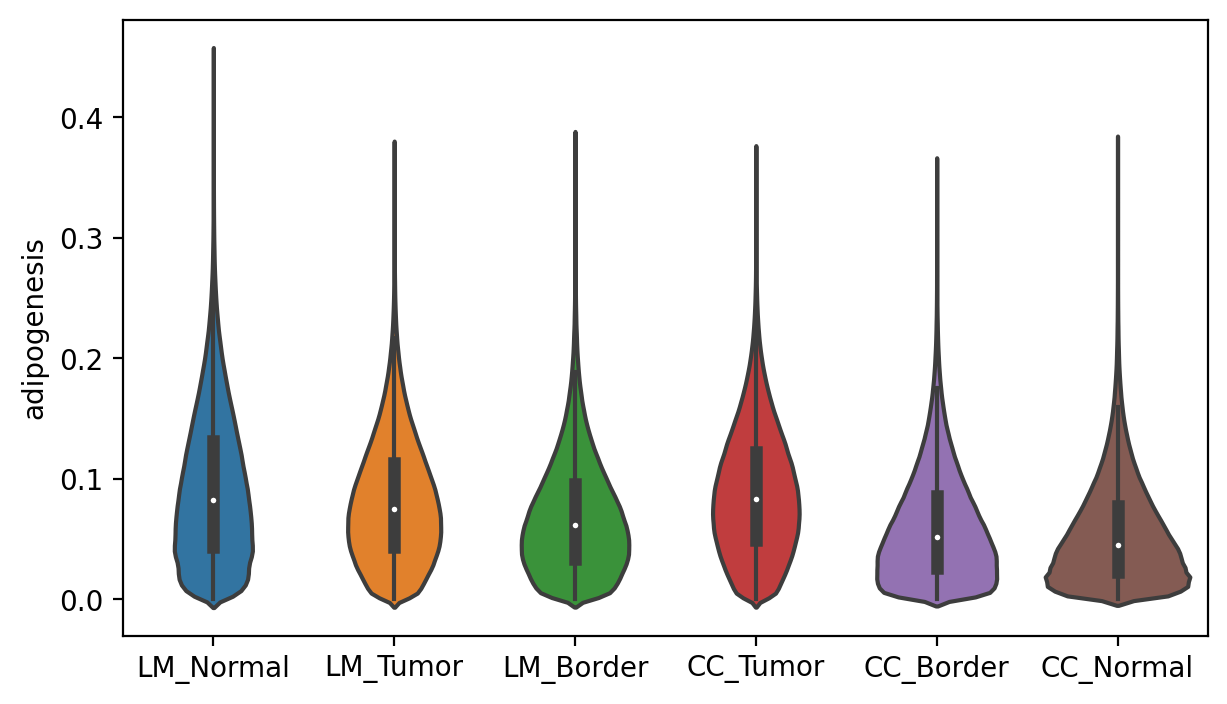

allograft_rejection


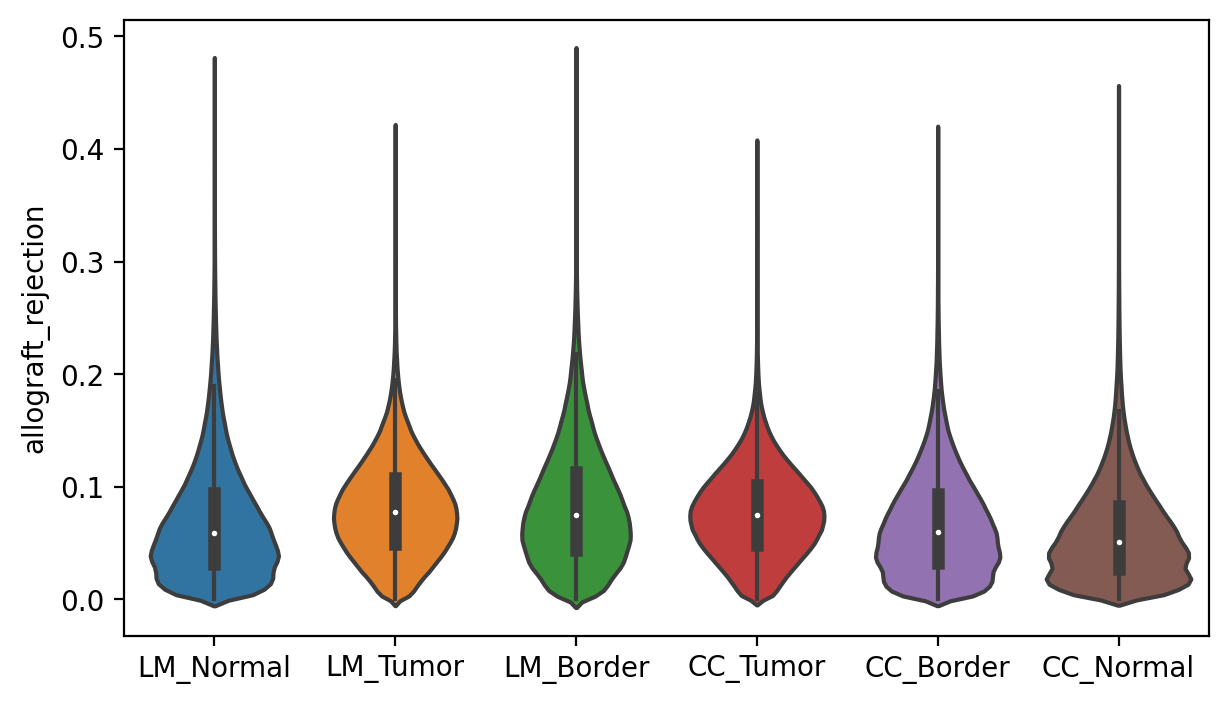

angiogenesis


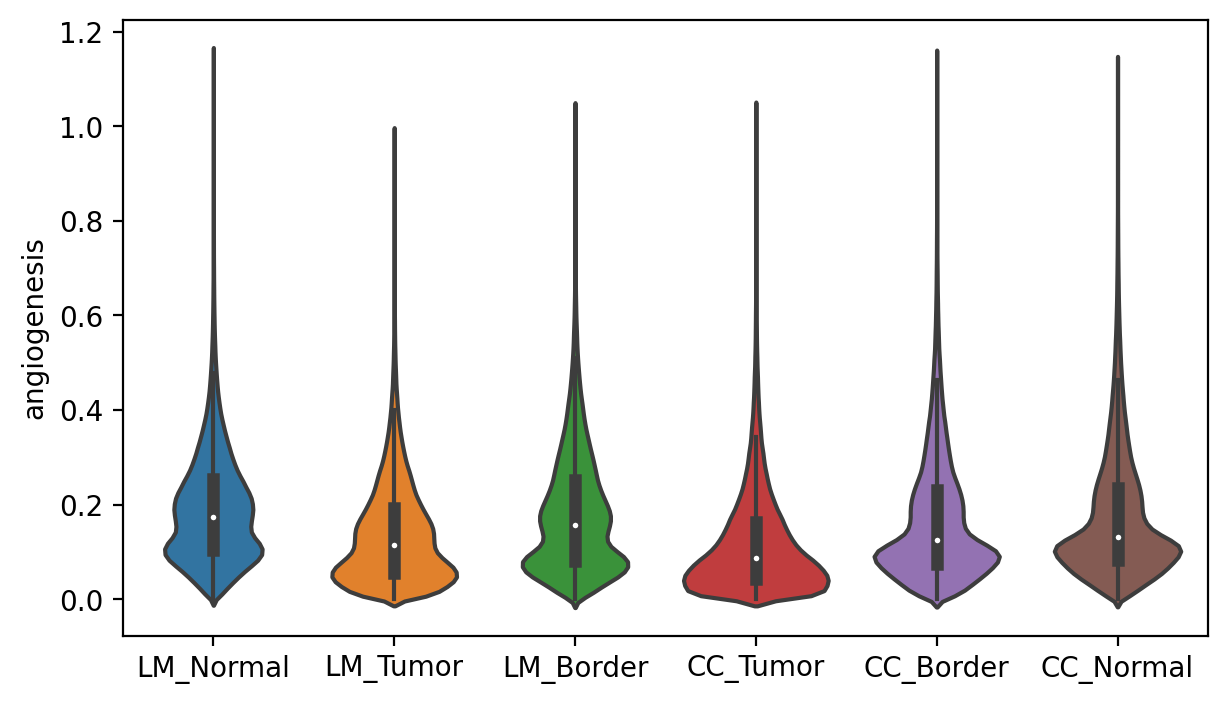

apoptosis


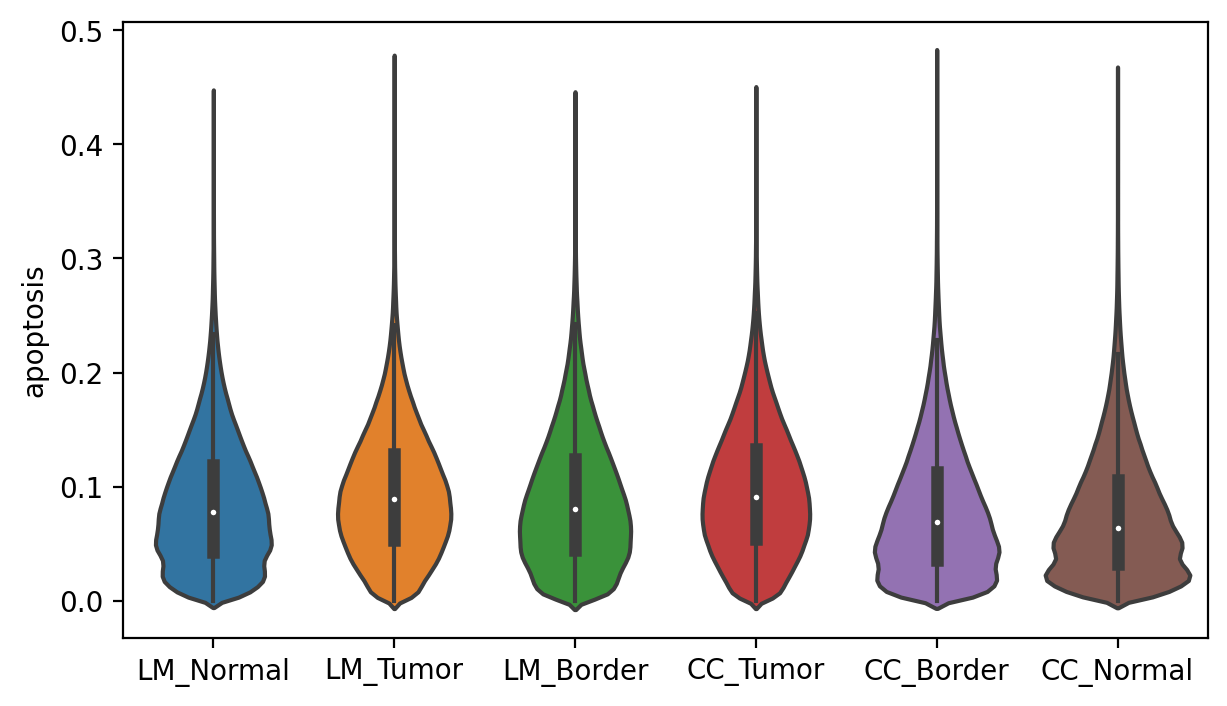

bile_acid_metabolism


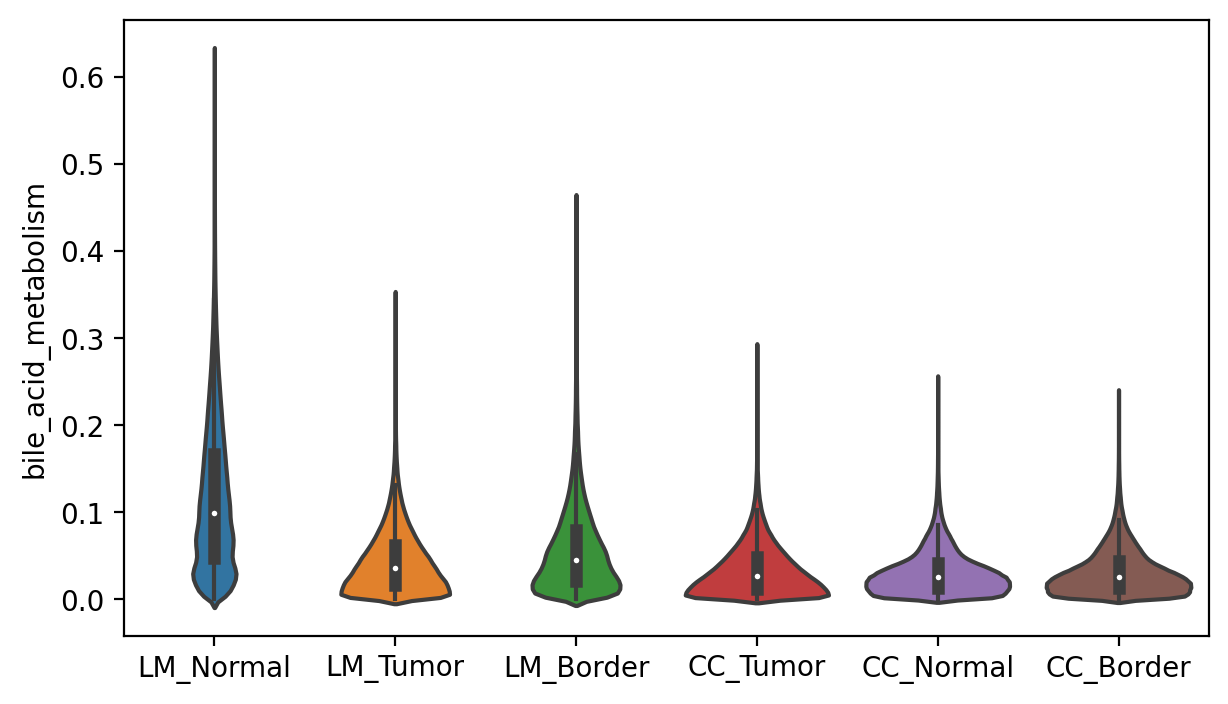

cholesterol_homeostasis


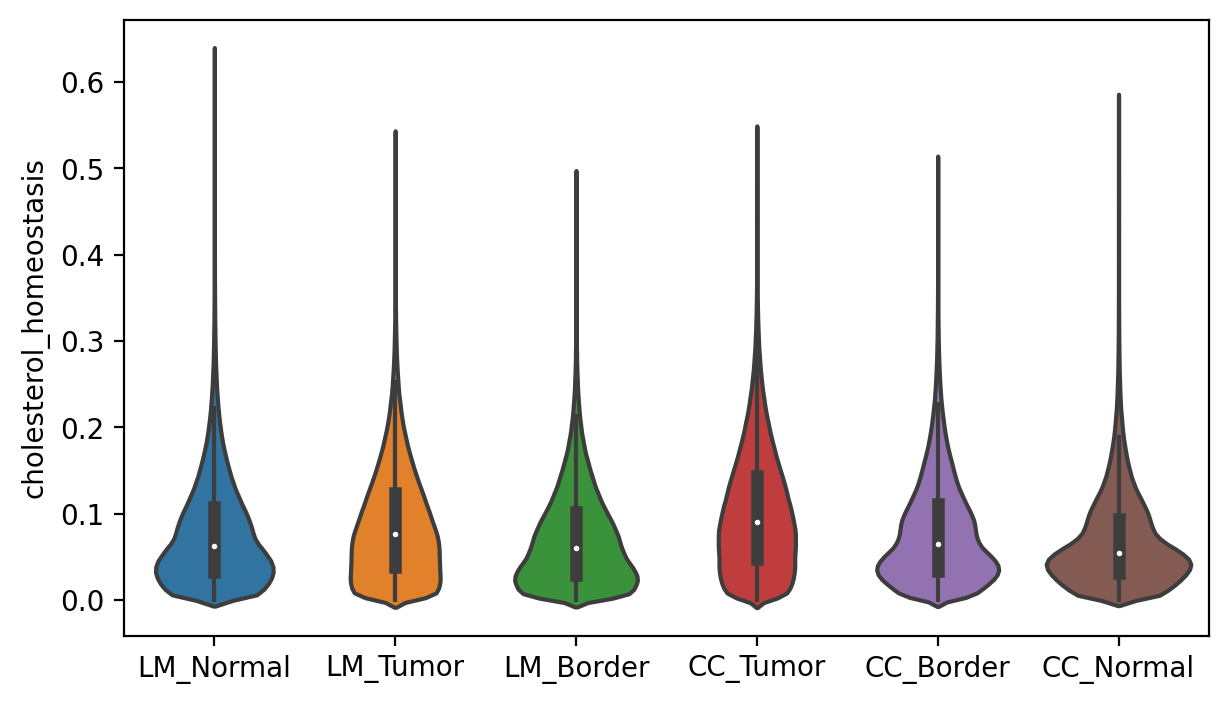

complement


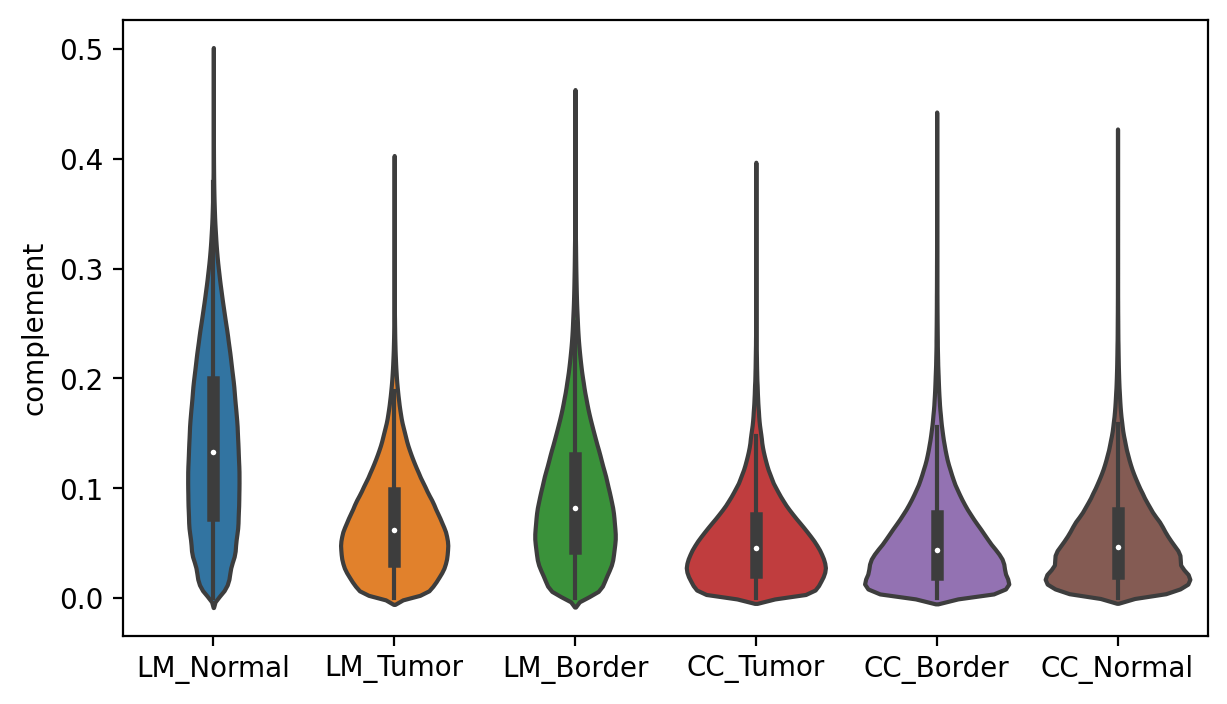

dna_repair


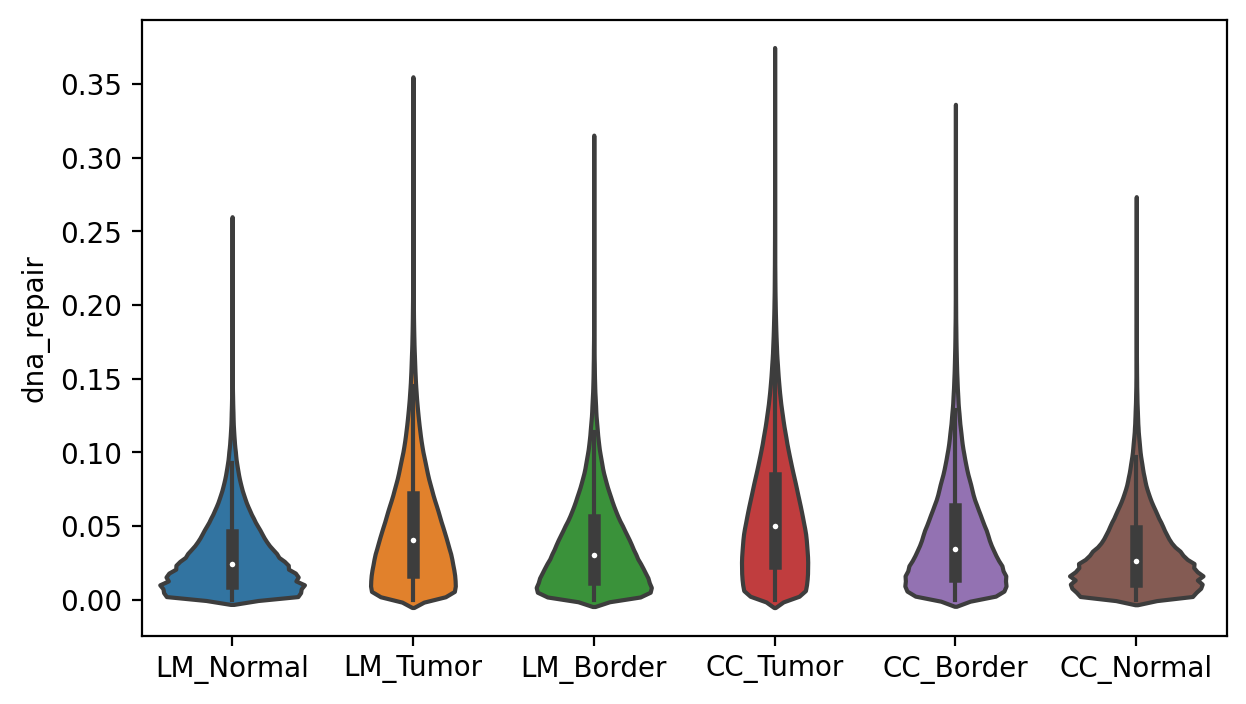

epithelial_mesenchymal_transition


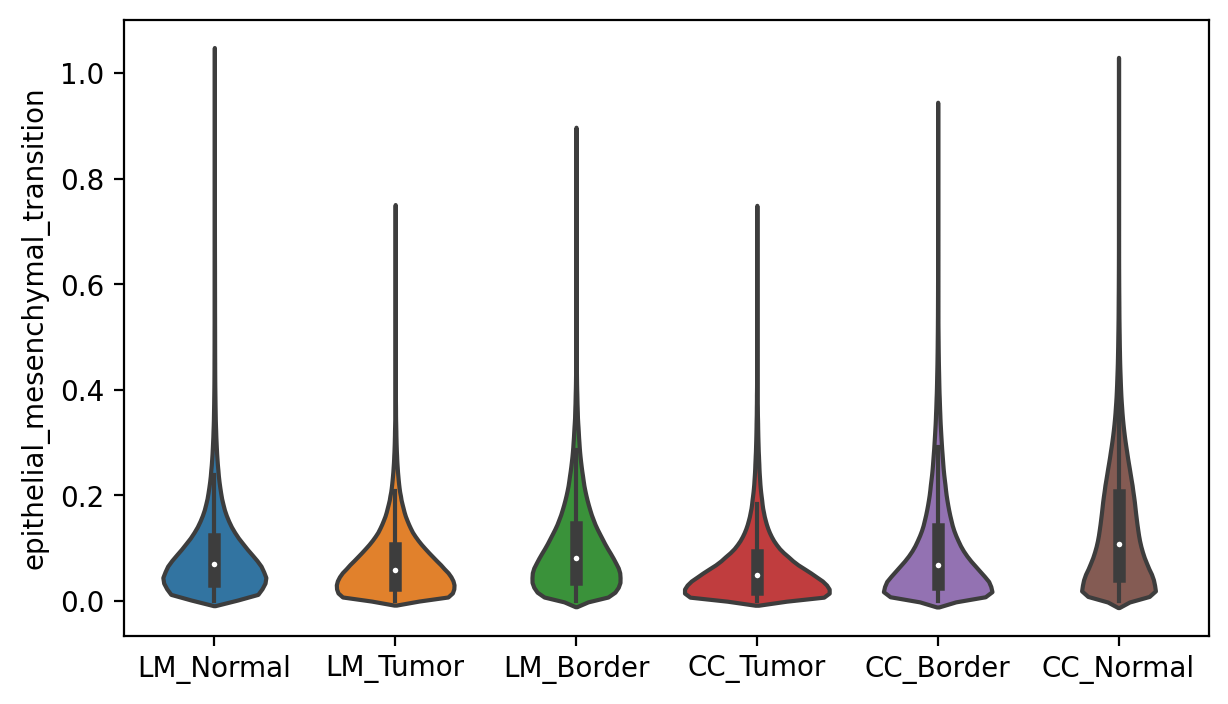

fatty_acid_metabolism


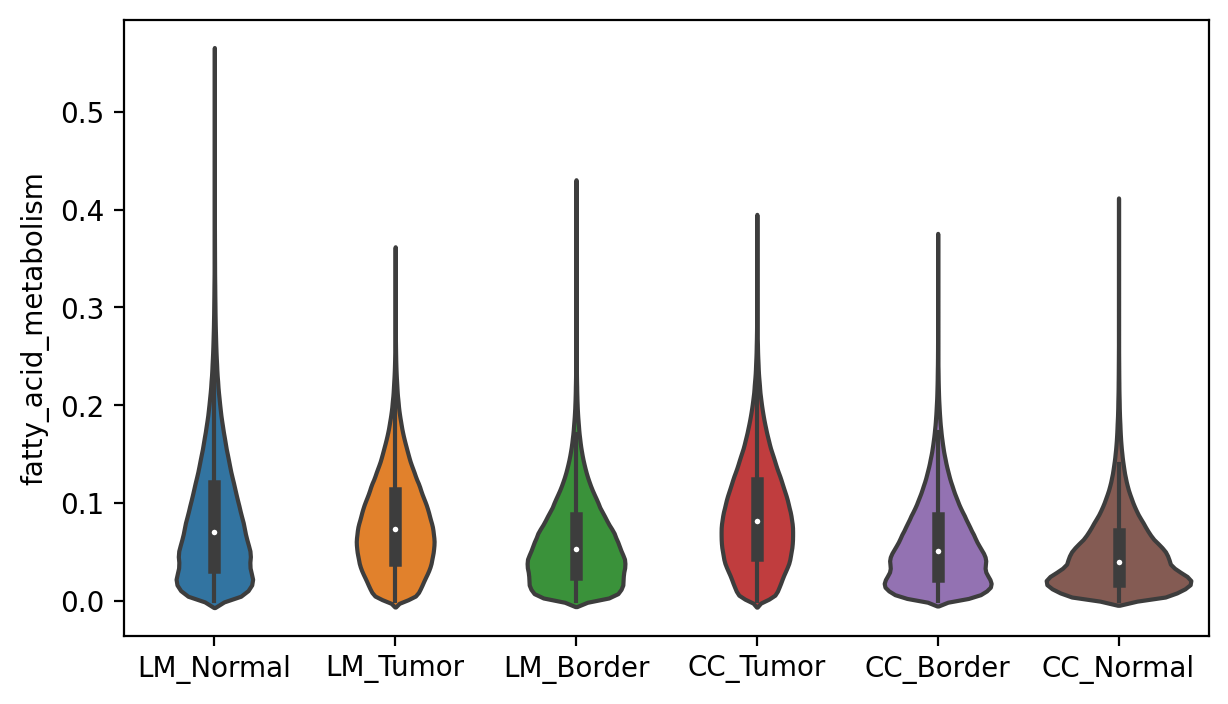

g2m_checkpoint


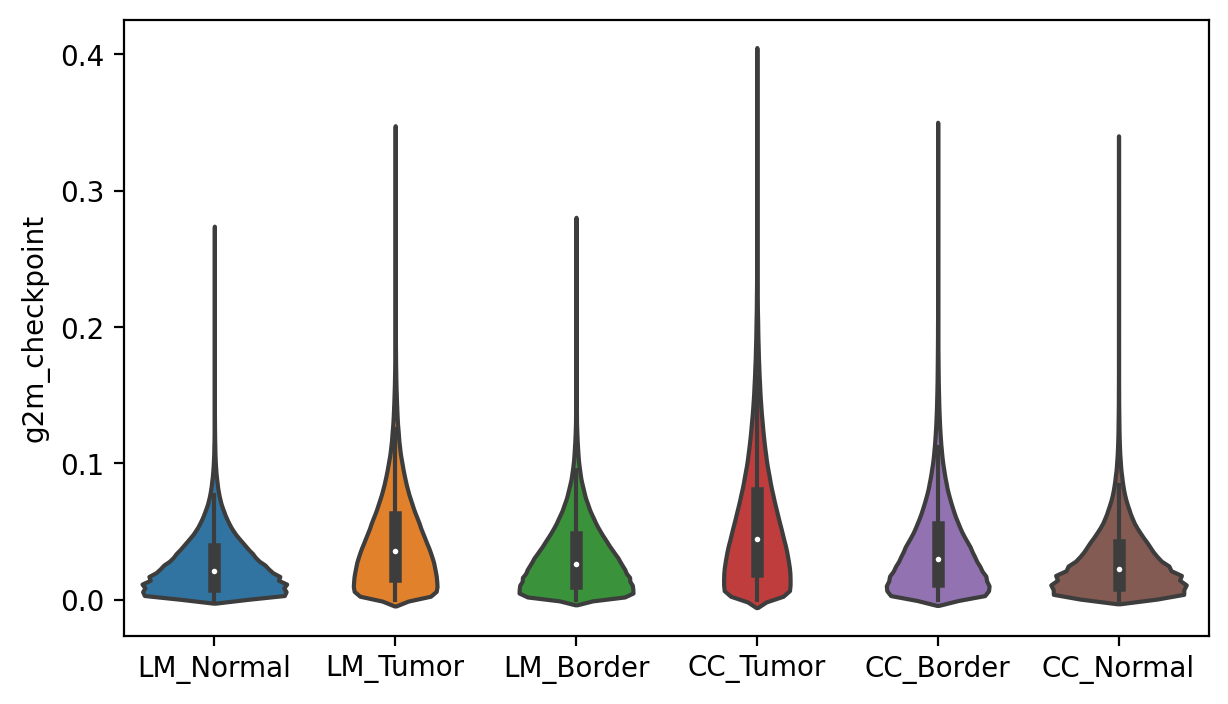

glycolysis


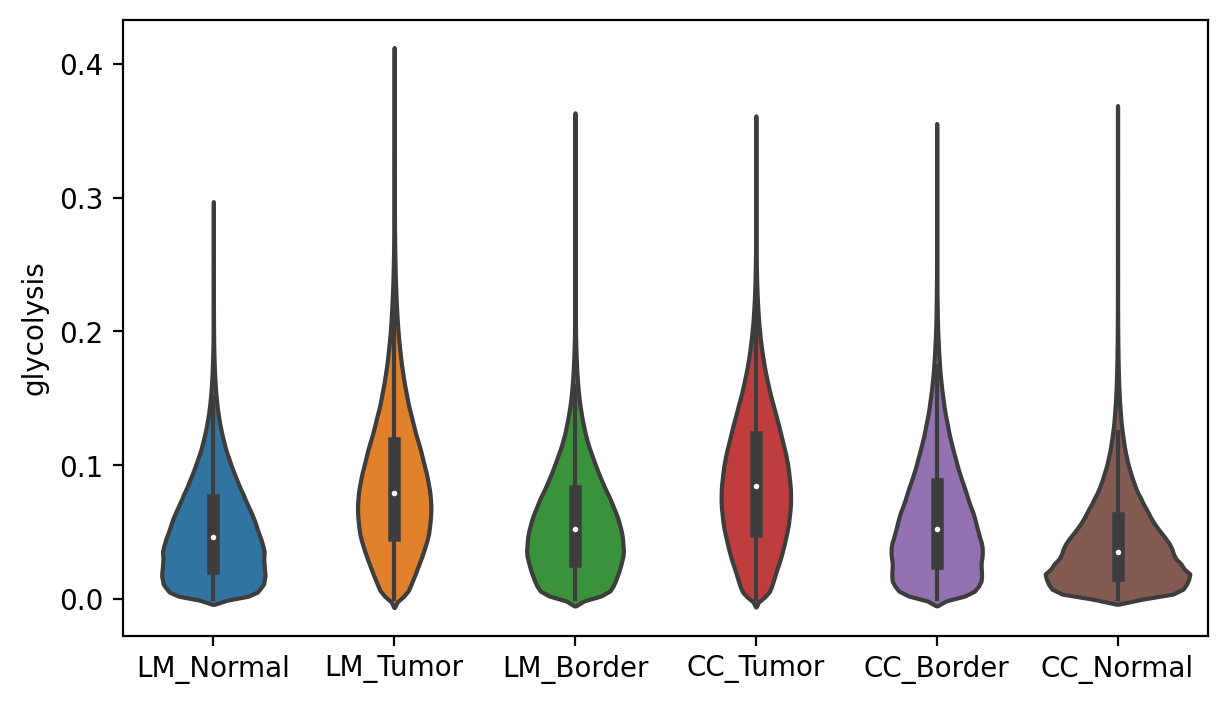

hypoxia


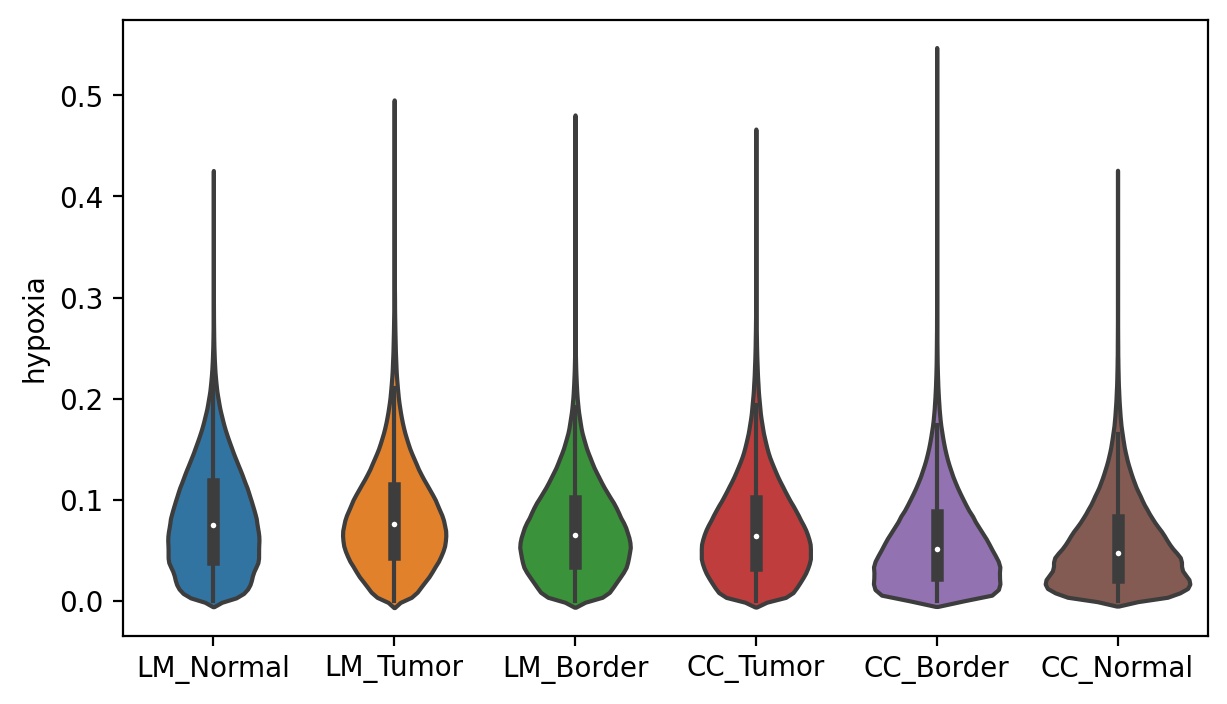

il2_stat5_signaling


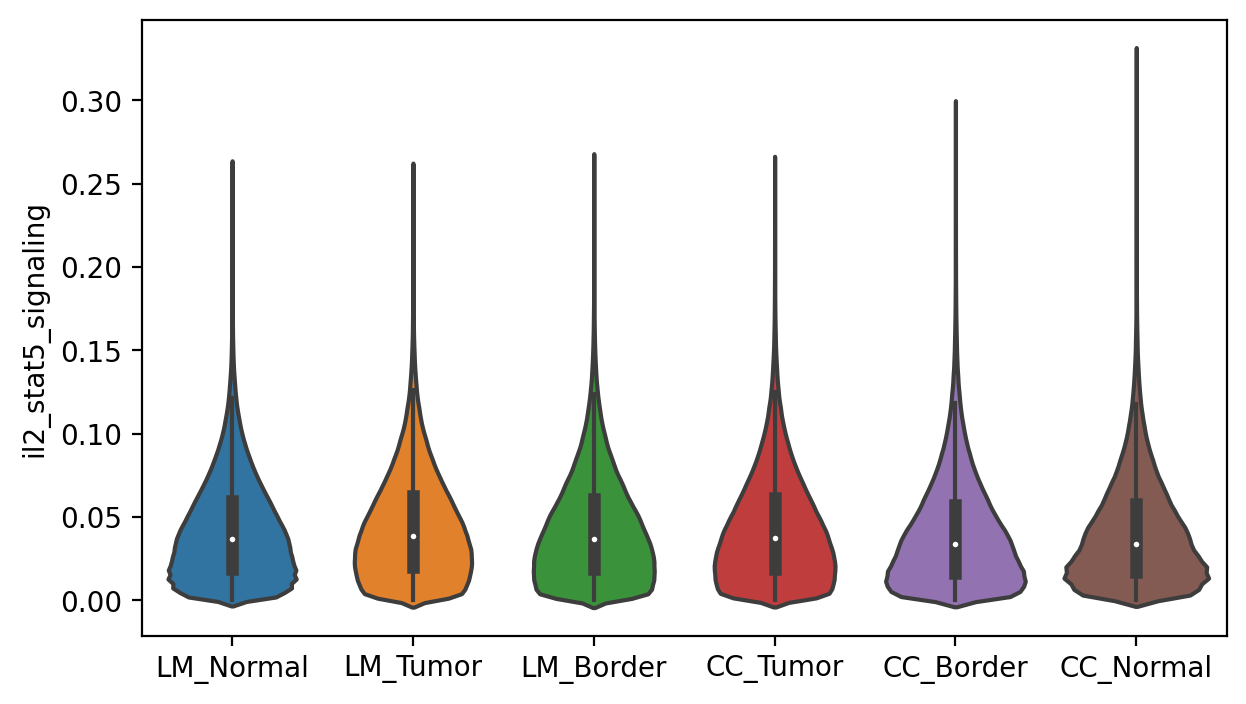

il6_jak_stat3_signaling


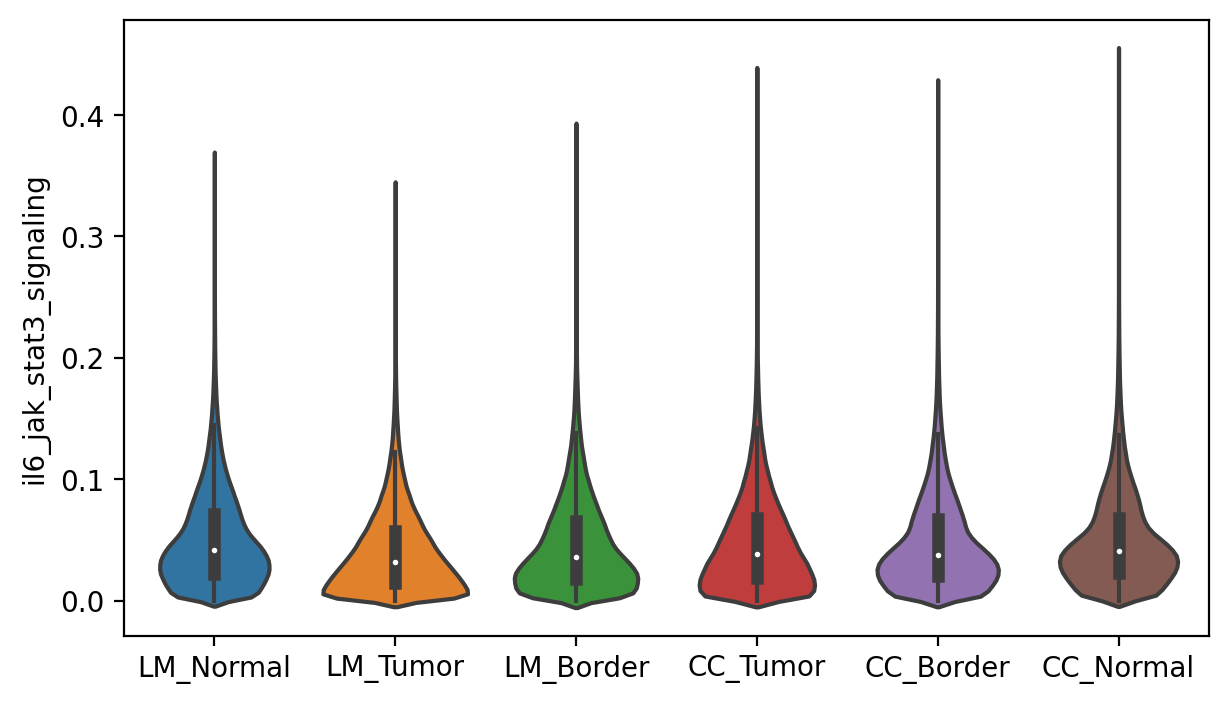

inflammatory_response


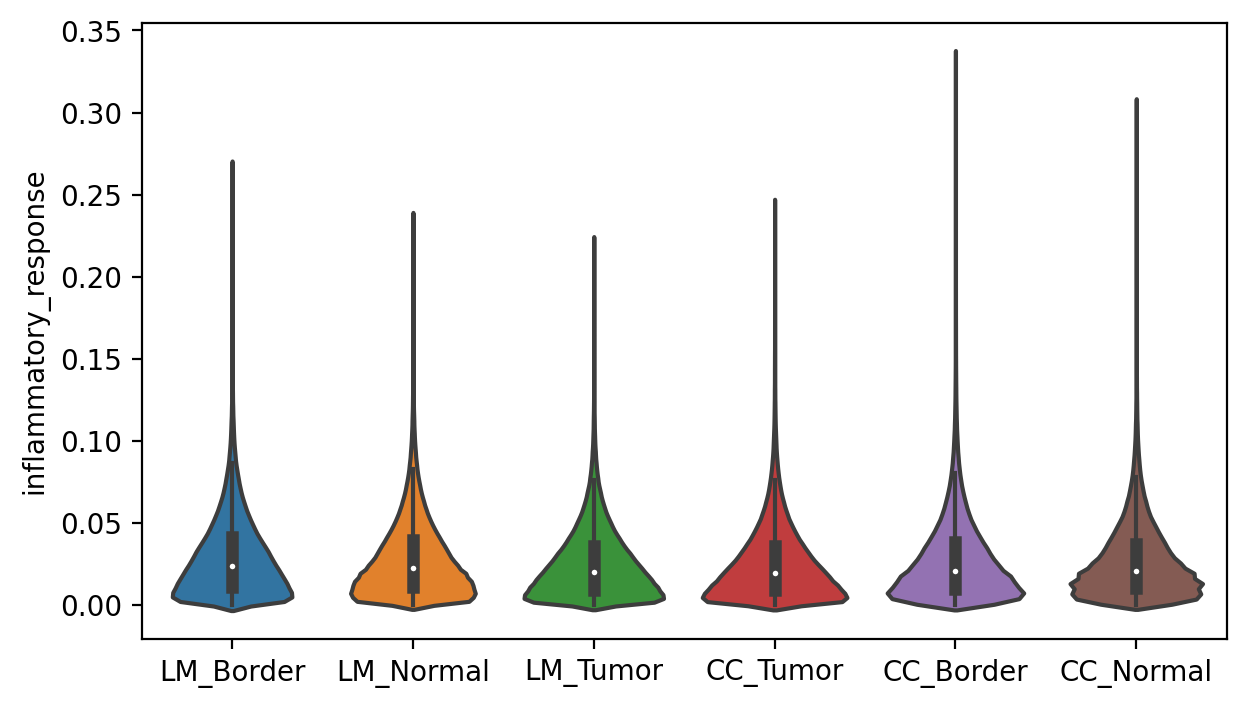

interferon_alpha_response


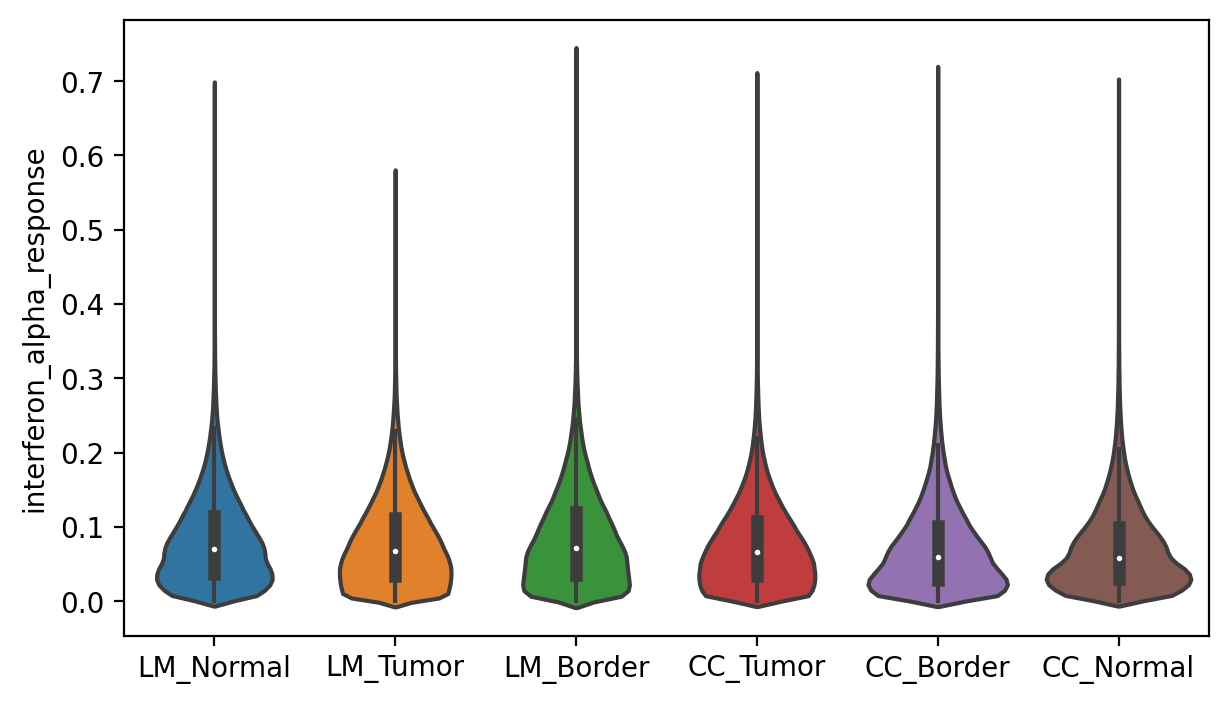

interferon_gamma_response


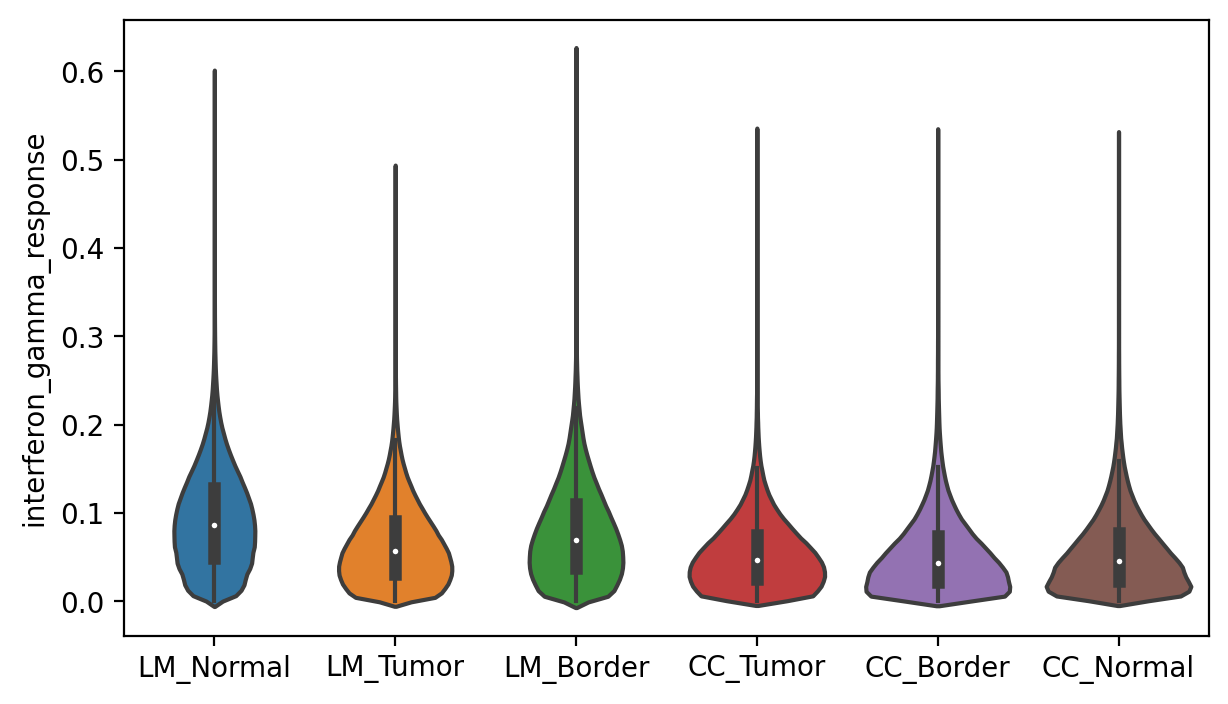

kras_signaling_up


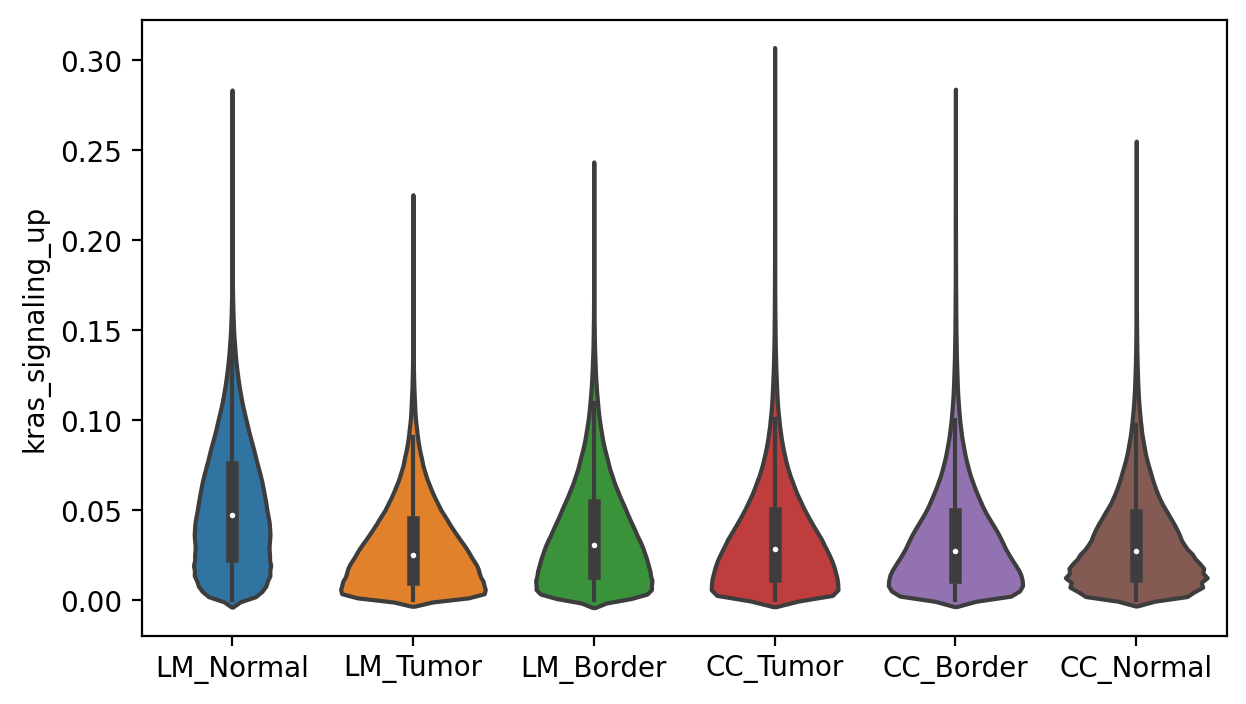

mitotic_spindle


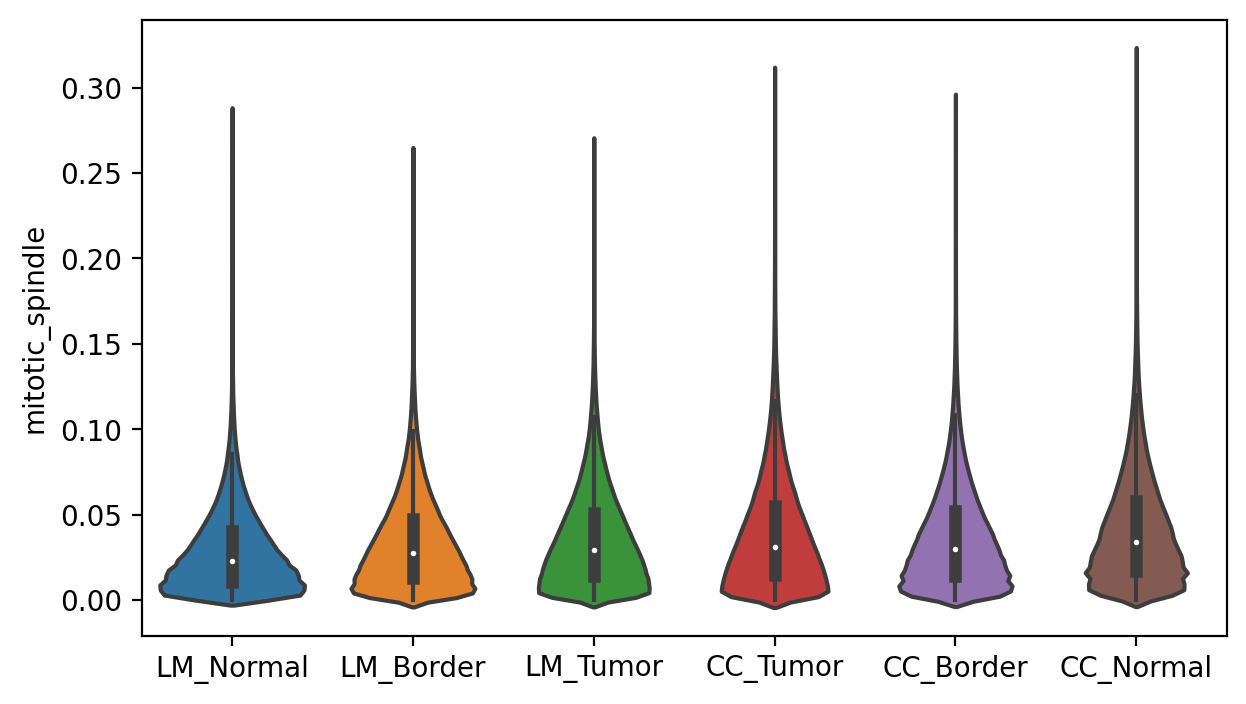

mtorc1_signaling


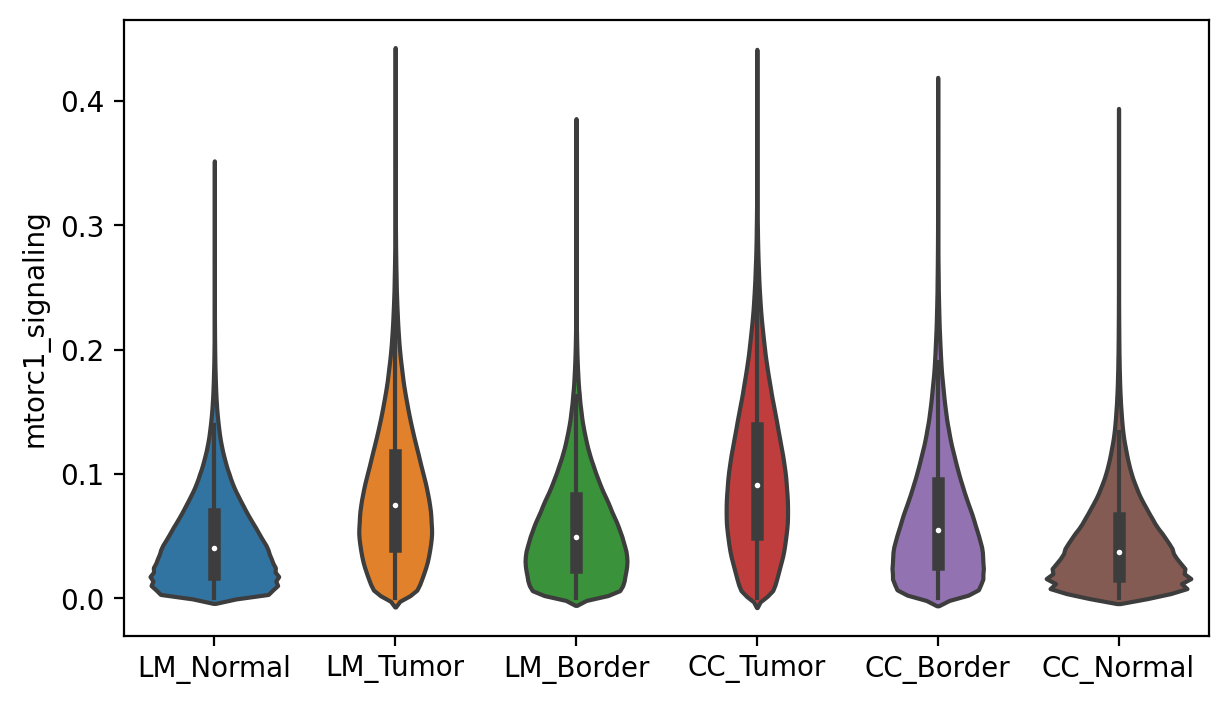

myc_targets_v1


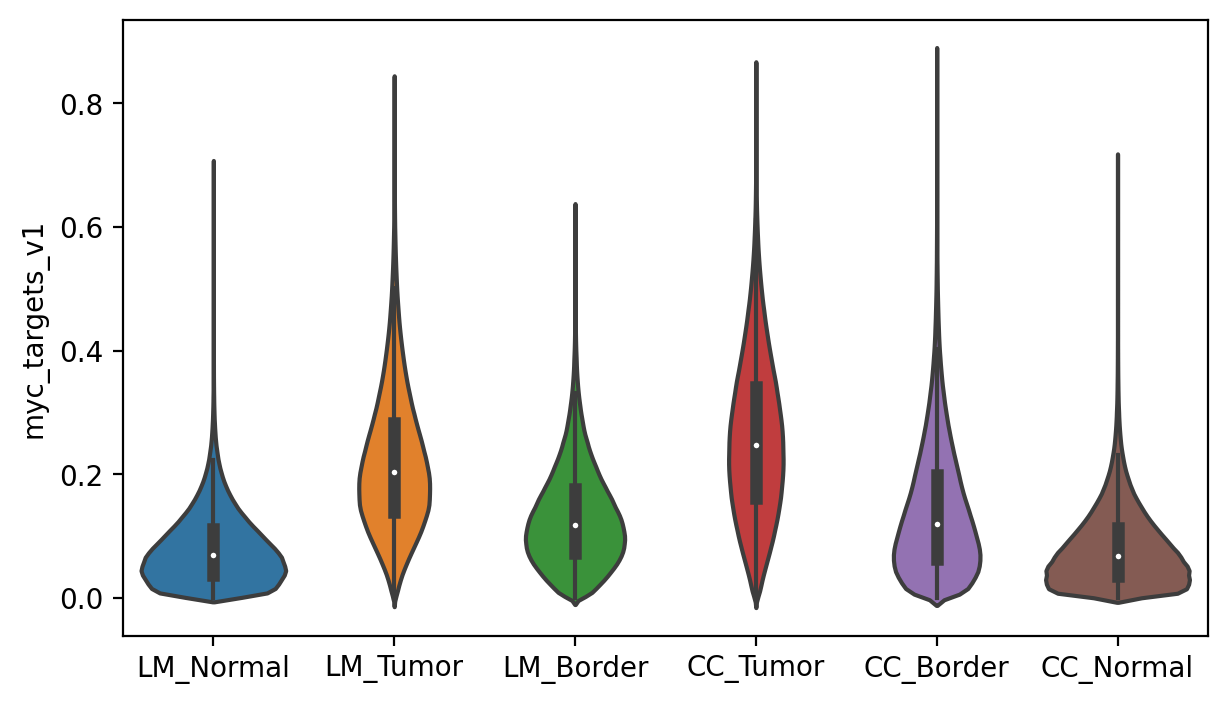

myc_targets_v2


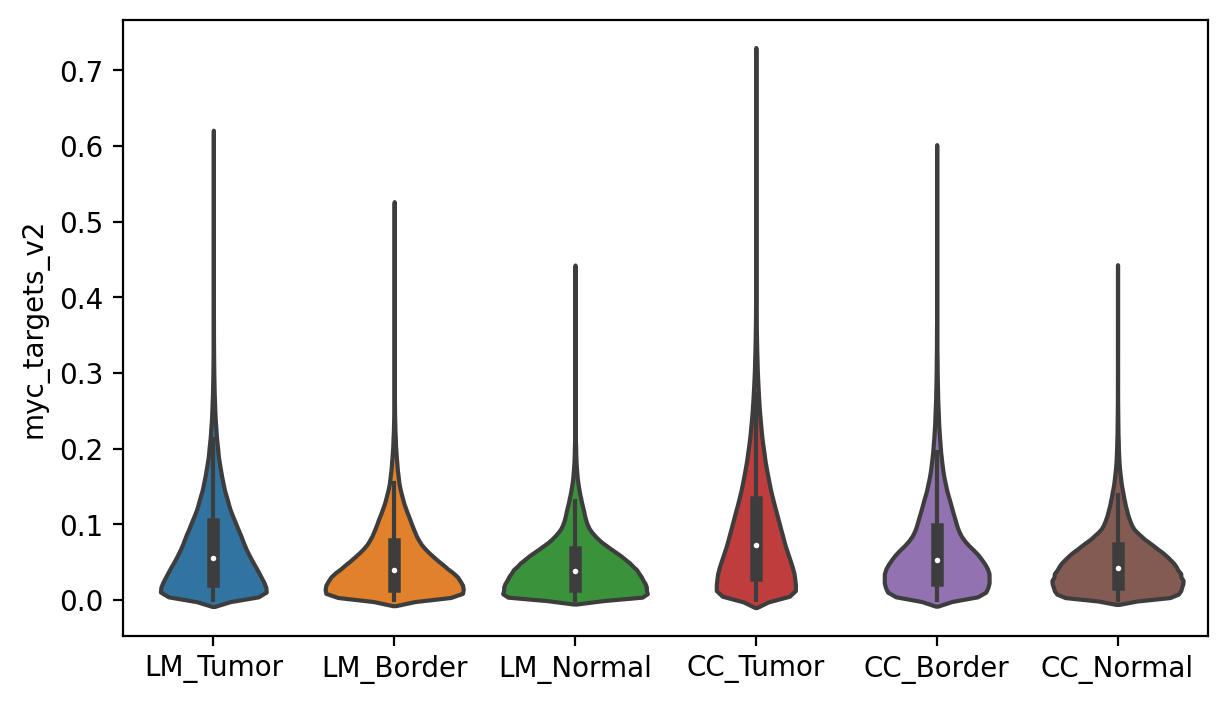

myogenesis


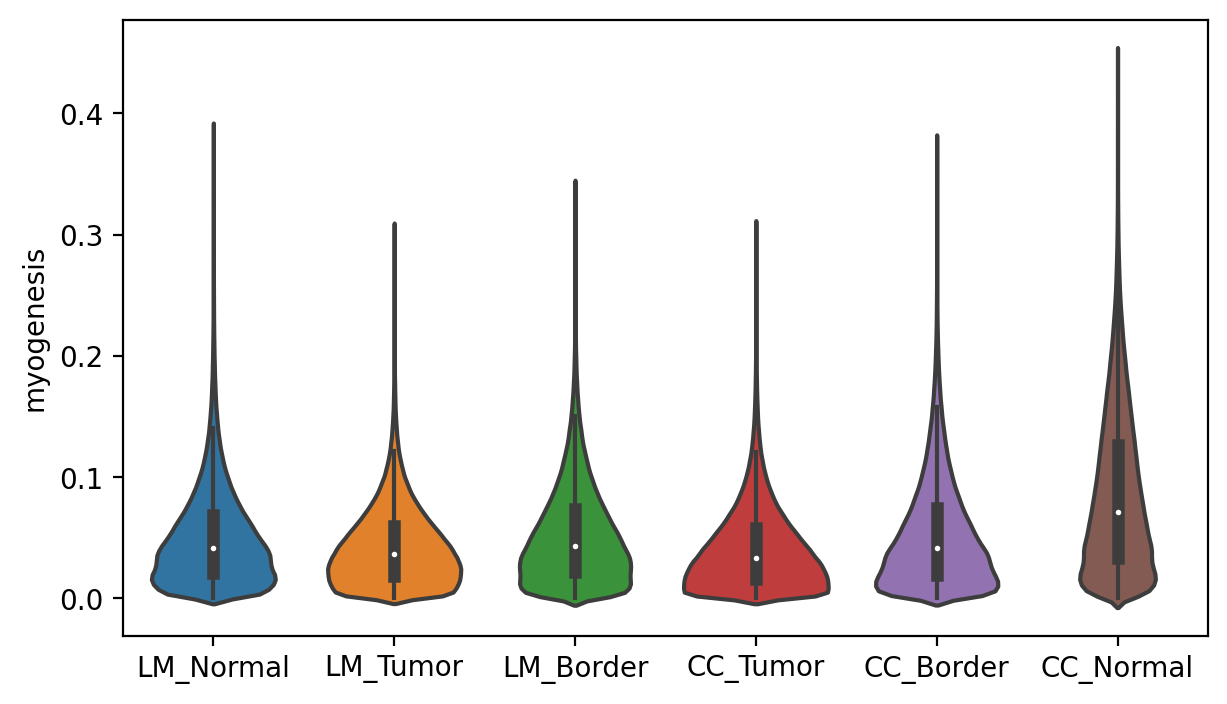

oxidative_phosphorylation


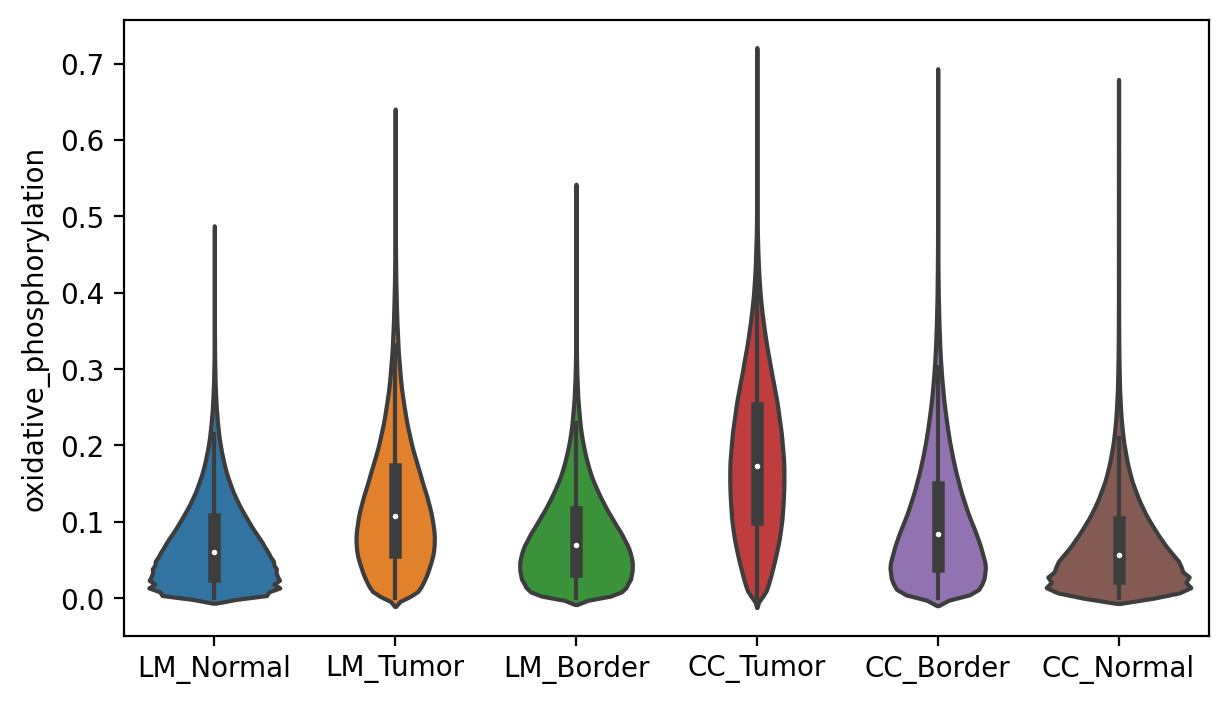

p53_pathway


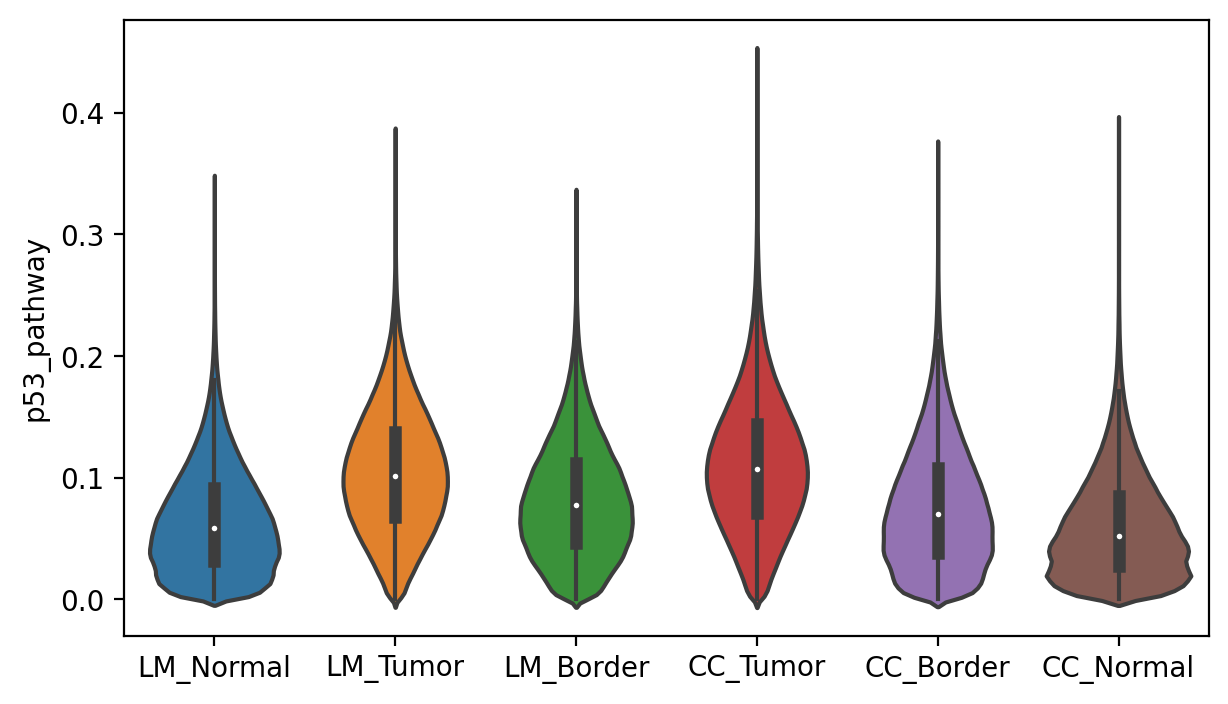

pi3k_akt_mtor_signaling


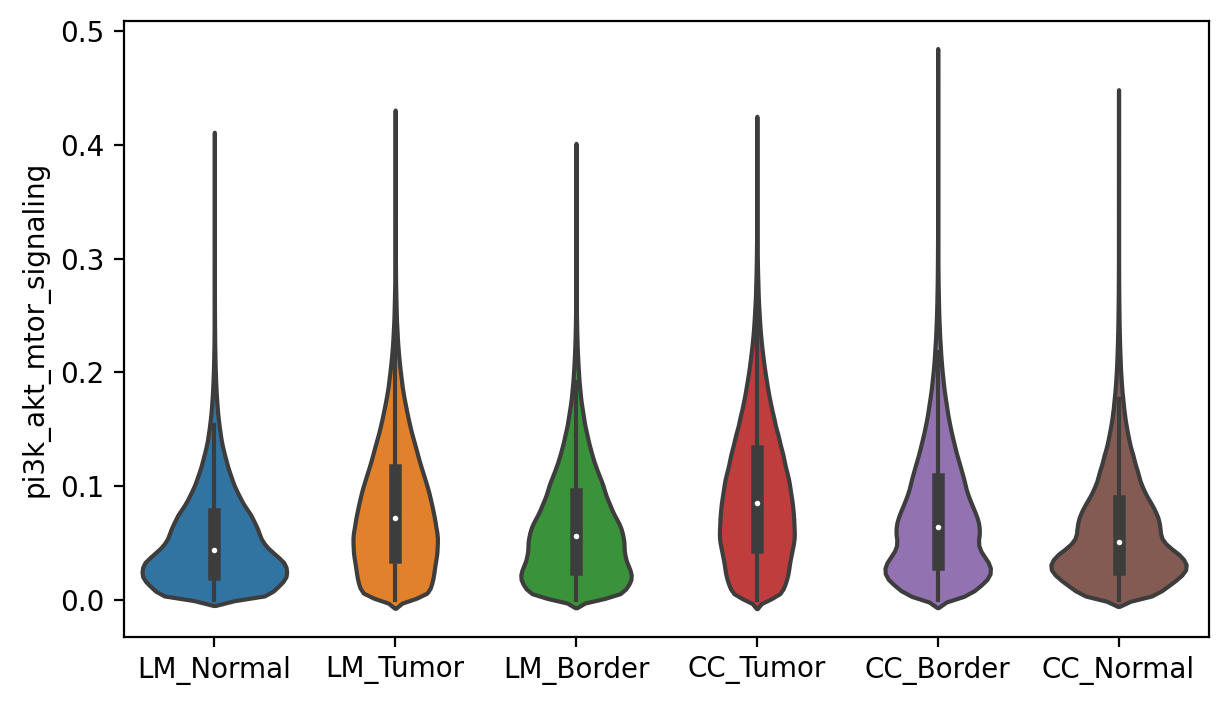

reactive_oxygen_species_pathway


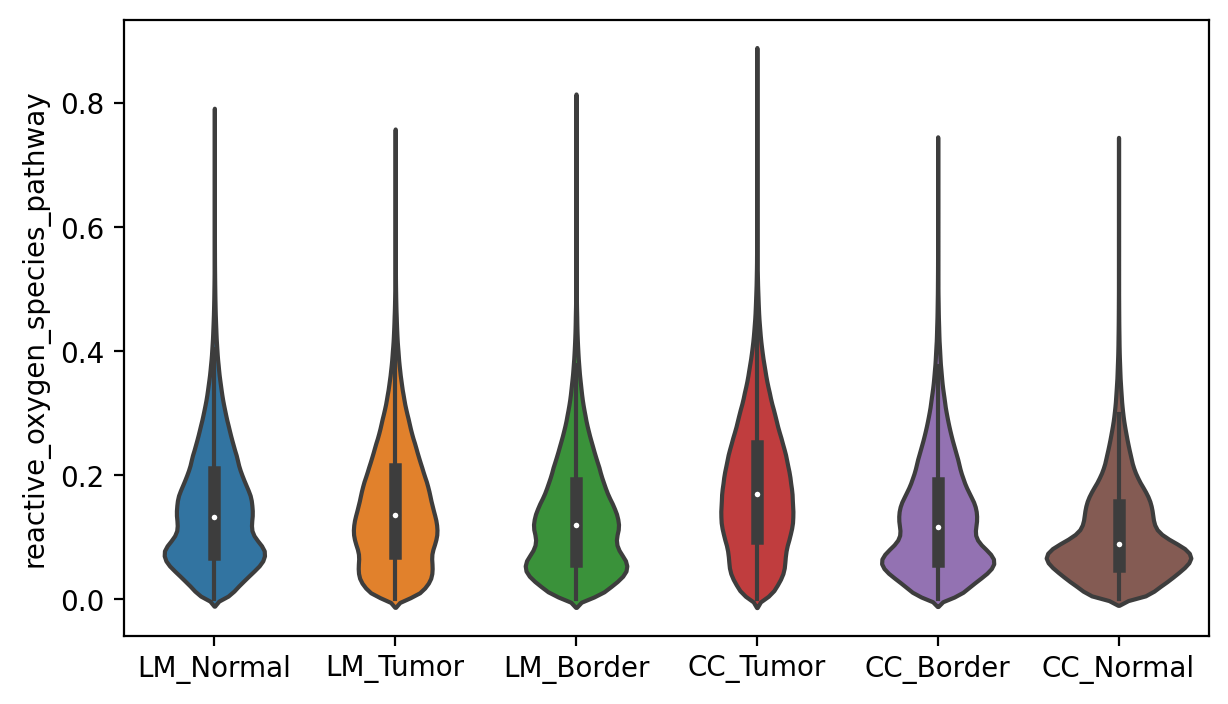

tgf_beta_signaling


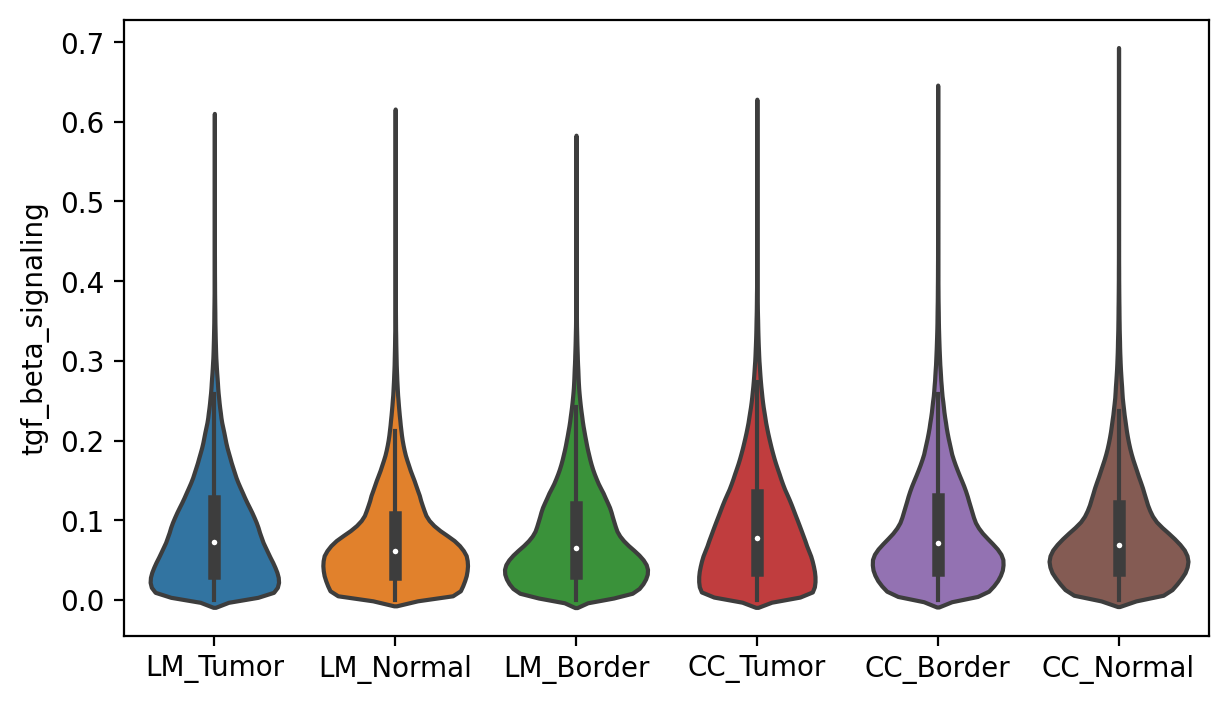

tnfa_signaling_via_nfkb


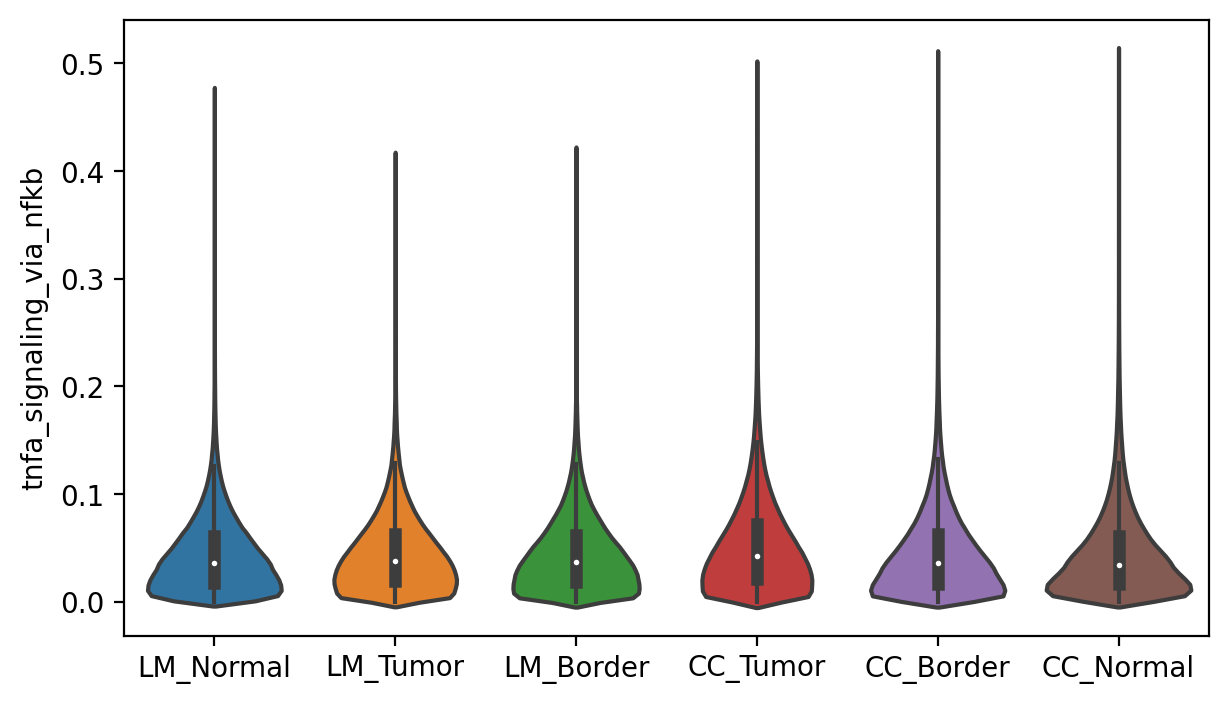

unfolded_protein_response


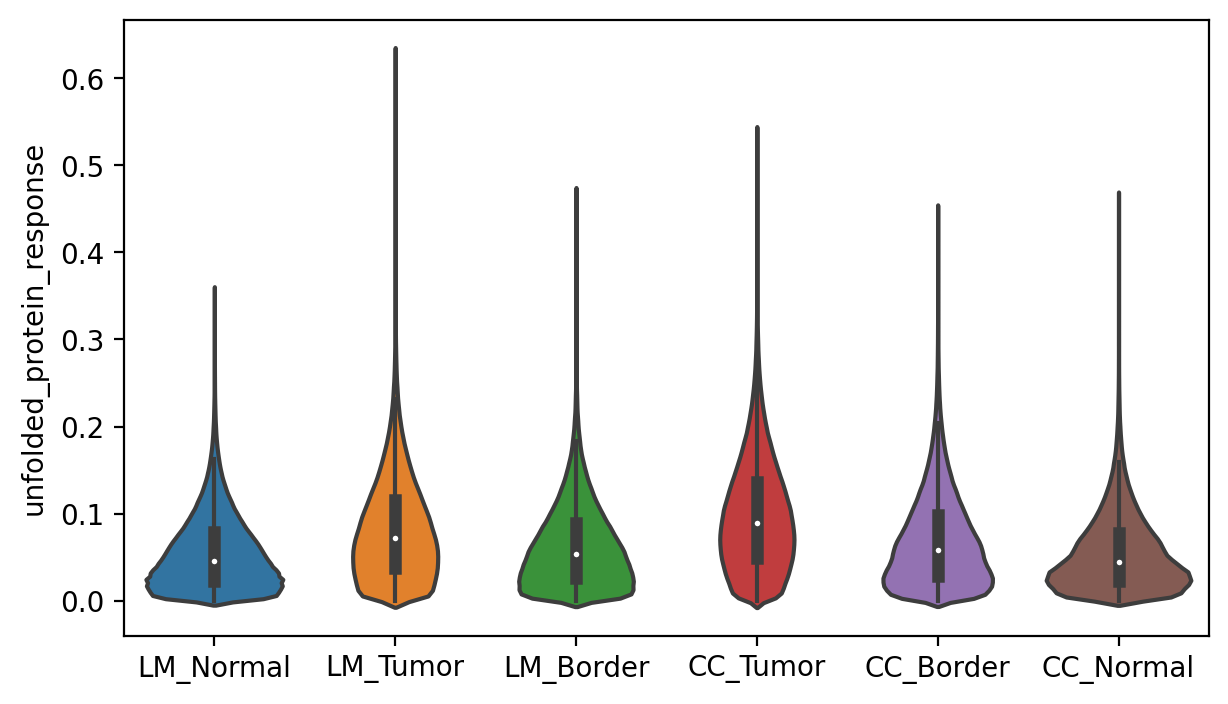

uv_response_dn


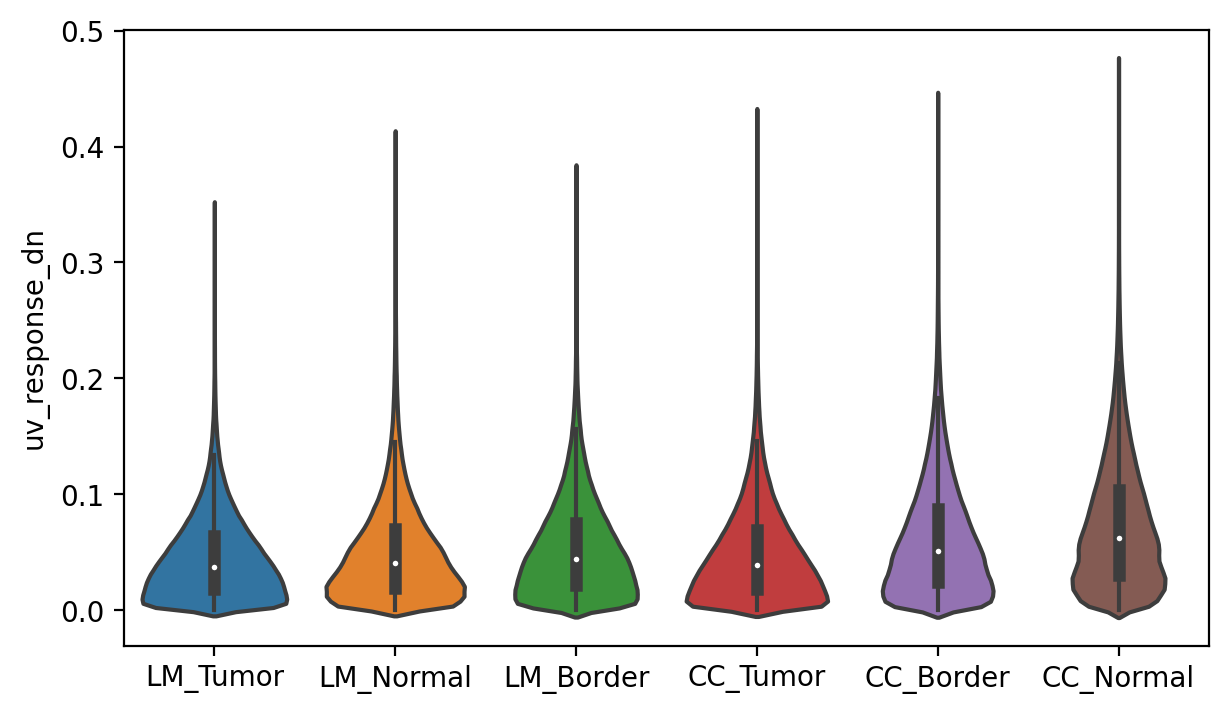

uv_response_up


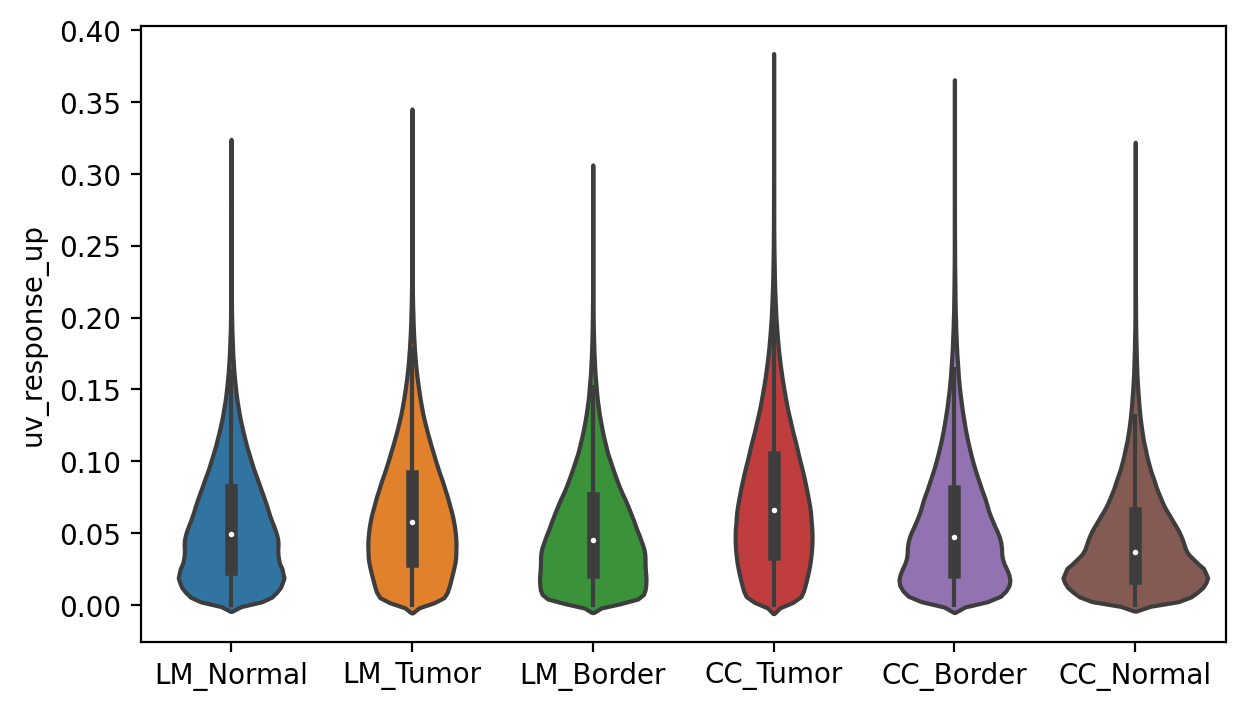

wnt_beta_catenin_signaling


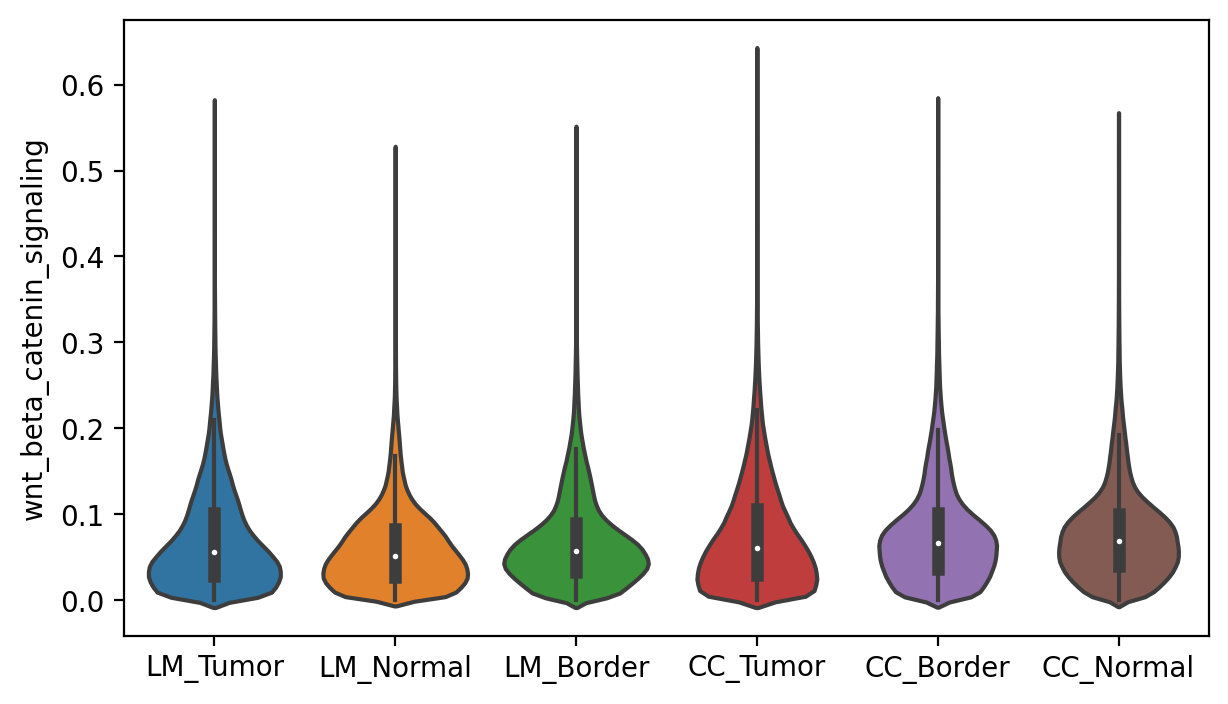

xenobiotic_metabolism


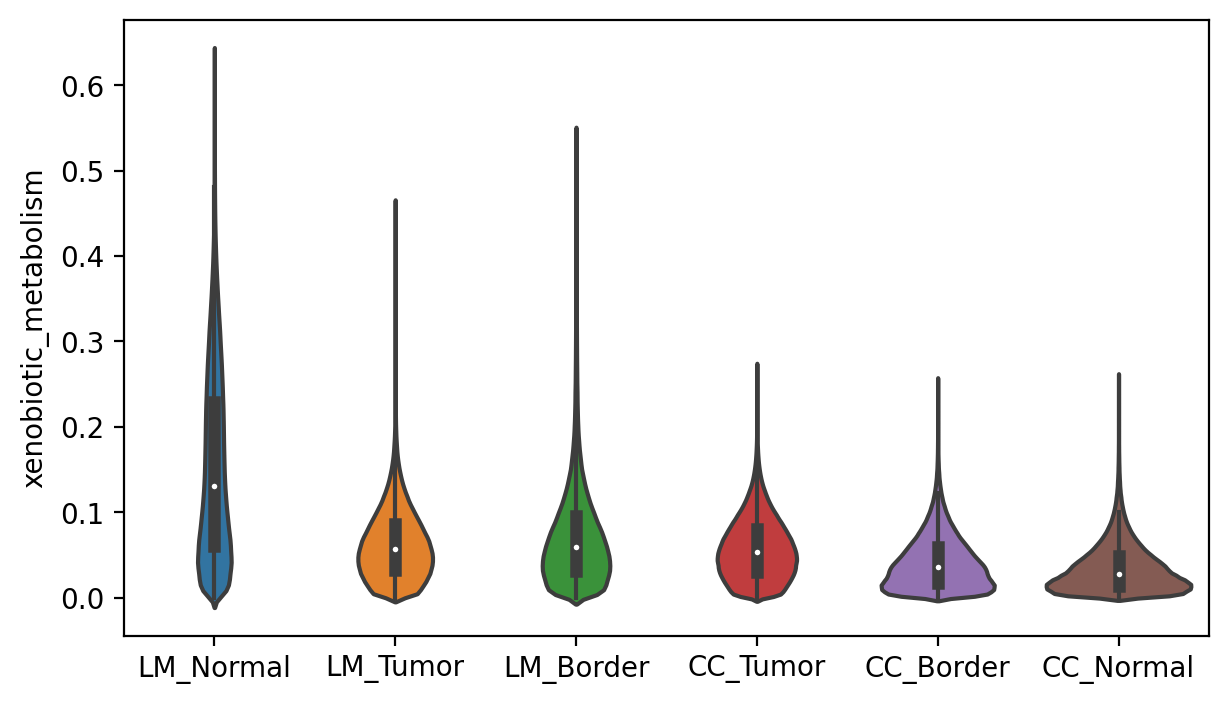

cytokine_receptor_interaction


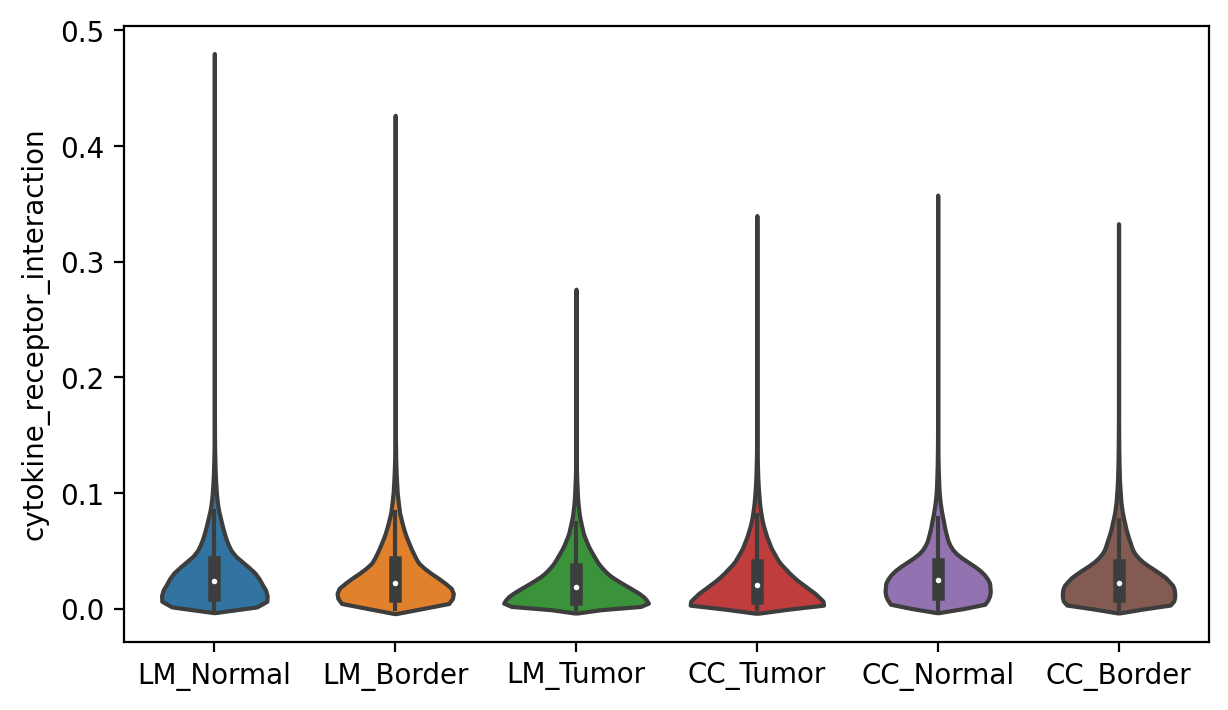

In [15]:
for name in score_names:
    print(name)
    tmp_df = hallmark_df[hallmark_df['hallmark']==name]
    tmp_df = tmp_df[tmp_df['score']>0]
    sns.violinplot(data=tmp_df, x='group', y='score')
    plt.ylabel(name)
    plt.xlabel('') 
    plt.show()
    